In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import re
import scipy.constants as c
from scipy.io import loadmat
from scipy.optimize import curve_fit
from scipy.signal import welch
from scipy.signal import find_peaks
from scipy.signal import periodogram
from scipy.interpolate import interp1d
import scipy.signal as sig
import math
import string
import pandas as pd
import time
import json
import csv

# Gui stuff.
import tkinter
from tkinter import ttk
from PIL import ImageTk, Image
from tkinter import filedialog
from matplotlib.backends.backend_tkagg import (
    FigureCanvasTkAgg, NavigationToolbar2Tk)
# Implement the default Matplotlib key bindings.
from matplotlib.backend_bases import key_press_handler
from matplotlib.figure import Figure
from matplotlib.backend_bases import MouseButton
#plt.style.use("dark_background")

# Multithreading
from threading import Thread
# Multiprocessing
import multiprocessing
multiprocessing.freeze_support()
from multiprocessing import Pool


# Split into like 1000 sections for each trace, average those and find variance of each slice.
# Allan variance (do it).

In [2]:
# Functions to be fitted.
def sqq(omega,omegaq,Gammacm,Tcm,M):
    return ((abs(Gammacm)*c.k*abs(Tcm))/(np.pi*abs(M)))/((omega**2-abs(omegaq)**2)**2+(abs(Gammacm)**2)*(abs(omega)**2))

def ssqq(omega,omegaq,Gammacm,a):
    return ((abs(Gammacm)*abs(a))/((omega**2-abs(omegaq)**2)**2+(abs(Gammacm)**2)*(abs(omega)**2)))

In [3]:
# Misc.
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def progress_bar(i,L,w):
    pr = i/L
    print(2*w*' ', end = '\r')
    print('[{}{}]{}/100%'.format(int(w*pr)*'#',int(w*(1-pr))*'.',round(100*pr,1)),end='\r')

def count_e(nested_list):
    return sum(count_elements_nested_list(item) if isinstance(item, list) else 1 for item in nested_list)

In [4]:
class Rod_Gamas:
    def __init__(self, T_s, l, R, D, p):
        self.l = l
        self.R = R
        self.p = p
        self.T = 300
        self.M = np.pi * R**2 * l * D
        self.alpha_c = 0.65 # Assuming surrounding gas is N_2.
        self.gamma_s = np.sqrt(T_s/self.T) # T_s = surface temp, # T = gas temp; (maybe ~1).
        self.m = 28.0134/(1000*c.N_A) # Mass of gas molecule (N_2).
        self.ng  = p/(c.k*self.T) # Gas density.

    def cm_t(self):
        return (self.ng*self.R*self.l*np.sqrt(2*np.pi*self.m*c.k*self.T)/self.M) * (2+self.alpha_c(-1/2 + np.pi*self.gamma_s/4 + self.R/self.l))

    def cm_p(self):
        return (self.ng*self.R*self.l*np.sqrt(2*np.pi*self.m*c.k*self.T)/self.M) * (4*self.R/self.l+self.alpha_c*(1 - 2*self.R/self.l + np.pi*self.gamma_s*self.R/(2*self.l)))

    def rot_t(self):
        return (self.ng*self.R*self.l*np.sqrt(2*np.pi*self.m*c.k*self.T)/self.M) * (self.l**2/(3*self.R**2 + self.l**2))* (2 + 12*(self.R/self.l)**3 + self.alpha_c*(-1/2 + np.pi*self.gamma_s/4 + 3*self.R/self.l + 6*(self.R/self.l)**2 + (3*np.pi*self.gamma_s/2 - 6)*(self.R/self.l)**3))

    def rot_p(self):
        return (self.ng*self.R*self.l*np.sqrt(2*np.pi*self.m*c.k*self.T)/self.M) * self.alpha_c*(2+ self.R/self.l)            


In [84]:
class data_processing:
    def __init__(self, d, CH, datatype):
        self.CH = CH
        self.datatype = datatype
        self.d = d
        if self.datatype == '.mat':
            a=1
            #self.restructureMat()
        elif self.datatype == '.csv':
            #a=1
            self.restructureBasic()
        self.split_data = []
        self.processed_data = []
        
        self.xs = np.asarray(self.d[0][list(self.d[0].keys())[0]])
        self.Ti = (self.xs[-1] - self.xs[0])/self.xs.shape[0]
        #self.l = self.xs.shape[0]
        self.l = self.xs[-1] - self.xs[0]
        self.scale_x = 1e3
        
    def restructureBasic(self):
        restructuredData = []
        for i in range(len(self.d)):
            restructuredData.append({})
            for j in range(len(self.d[i])):
                for k in range(len(self.d[i][j])):
                    if j == 0:
                        restructuredData[i][self.d[i][j][k]] = []
                    else:
                        try:
                            restructuredData[i][self.d[i][0][k]].append(float(self.d[i][j][k]))
                        except ValueError:
                            break
        self.d = restructuredData
    
    def restructureMat(self):
            self.d = d#d[0][self.CH]
            self.Ti = d[0]['Tinterval'][0,0]
            self.l = d[0]['Length'][0,0]
            self.xs = np.linspace(0,self.l*self.Ti,self.l)

    def plot_time_series(self, ax, ax2, cal):
        points = 10000 #Number of points on final graph
        points_sep = round(len(self.xs)/points)
        if points_sep < 1:
            points_sep = 1
        ax.scatter(self.xs[::points_sep], np.asarray(self.d[0][self.CH][::points_sep])*cal, color='tab:red', s = 1, alpha = 0.8)
        ax.set_title('Time Series Data (CH {})'.format(self.CH))
        ax2.set_xlabel('Time (s)')
        ax.set_ylabel('Voltage (V)')
        ax.set_xlim([self.xs[0],self.xs[-1]])
        ax2.set_xlim(ax.get_xlim())
        
    def plot_full_PSD(self, ax, ax2, cal):
        #plt.figure(figsize=(10, 3.5), dpi=80)
        xf, pxx = periodogram(np.asarray(self.d[0][self.CH])*cal,fs=1/self.Ti)
        ax.semilogy()
        points = 10000 #Number of points on final graph
        points_sep = round(len(xf)/points)
        if points_sep < 1:
            points_sep = 1
        ax.scatter(xf[::points_sep], pxx[::points_sep], color='black', s = 1, alpha = 0.8 )
        ax.set_title('PSD (CH {})'.format(self.CH))
        ax2.set_xlabel('Frequency (kHz)')
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/self.scale_x))
        ax2.xaxis.set_major_formatter(ticks_x)
        ax.set_ylabel('Voltage ($V^2/Hz$)')
        ax.set_xlim([xf[0],xf[-1]])
        ax2.set_xlim(ax.get_xlim())
        
    def splitting_data(self, cal, freq = 3e5, osc = 1e4):
        
        self.split_length = int(self.l*self.Ti/(osc*(1/freq)))
        self.split_data = []    
            
        for i in range(len(self.d)):
            r = np.asarray(self.d[i][self.CH]).shape[0]%self.split_length
            self.split_data.append(np.split(np.asarray(self.d[i][self.CH])[:-r]*cal, self.split_length)) 
        self.split_data = np.asarray(self.split_data)
        
    def average(self):
        # Find Summed PSDs.
        lpxx = []
        # For each channel, adds all periodograms generated from d seperate runs together.
        for i in range(len(self.d)):
            for j in range(self.split_data.shape[1]):
                # This is done to limit too much memory allocation.
                if i == 0: 
                    xf, pxx = periodogram(self.split_data[i,j,:],fs=1/self.Ti)
                else:
                    _, pxx = periodogram(self.split_data[i,j,:],fs=1/self.Ti)
                lpxx.append(pxx[1:])
                
        lpxx = np.asarray(lpxx)
        mpxx = np.mean(lpxx, axis= 0 )
        spxx = np.std(lpxx, axis= 0 )
        epxx = np.std(lpxx, axis= 0 )/np.sqrt(lpxx.shape[0])
        self.processed_data = [xf[1:], mpxx, spxx, epxx, self.CH]
        
    def binning(self, cal, binsize):
        xf, pxx = periodogram(np.asarray(self.d[0][self.CH])*cal,fs=1/self.Ti)

        xf = sig.convolve(xf, np.ones(binsize), mode = 'same')/binsize
        binned = sig.convolve(pxx, np.ones(binsize), mode = 'same')
        binned_err = []
        
        a = int(binsize/2)
        b = a
        lpxxmb = len(pxx)-b
        for i in range(len(pxx)):
            if i > a and lpxxmb > i:
                binned_err.append(np.std(pxx[i-a:i+b]))
            elif i > a:
                binned_err.append(np.std(pxx[i-a:i]))
            elif lpxxmb > i:
                binned_err.append(np.std(pxx[i:i+b]))
            
            
        mpxx = binned
        spxx = binned_err
        epxx = binned_err/np.sqrt(len(mpxx))
        self.processed_data = [xf, mpxx, spxx, epxx, self.CH]

    def plot_mean_errorbars(self, ax, ax2):
        xf, mpxx, epxx = self.processed_data[0], self.processed_data[1], self.processed_data[3]
        ax.semilogy()
        points = 10000 #Number of points on final graph
        points_sep = round(len(xf)/points)
        if points_sep < 1:
            points_sep = 1
        ax.errorbar(xf[::points_sep], mpxx[::points_sep], yerr = epxx[::points_sep], marker='', linestyle='',color='black', ms = 1, alpha = 0.8)
        ax.set_title('PSD Data (log10)')
        ax2.set_xlabel('Frequency (kHz)')
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/self.scale_x))
        ax2.xaxis.set_major_formatter(ticks_x)
        ax.set_ylabel('PSD ($V^2/Hz$)')
        ax.set_xlim([xf[0],xf[-1]])
        ax2.set_xlim(ax.get_xlim())

In [85]:
class fit_data:
    def __init__(self, processed_data):
        self.processed_data = processed_data
        self.popt = []
        self.pcov = []
        self.labels = []
        self.p = 0
        self.scale_x = 1e3
        
        
    def find_peaks(self, width_tuning, ax, ax2, peak_lim = 50):
        #width_tuning = 11
        #peak_lim = 50
        self.peak_list = []
        self.amp_list = []
        
        xf = self.processed_data[0]
        mpxx = self.processed_data[1]
        peaks = find_peaks(mpxx, width = width_tuning)[0]
        #print('Peaks: {}'.format(len(peaks)))
        if len(peaks) > peak_lim:
            print('Error: Too Many Peaks')
        for j in range(len(peaks)):
            self.peak_list.append(xf[peaks[j]])
            self.amp_list.append(mpxx[peaks[j]])
        self.peaks = peaks
        #peaks = np.append(peaks, [1200]) #Temporary additional peak
        #peak_list.append(55000) #Temporary additional peak
        #amp_list.append(2e-9) #Temporary additional peak
        self.p = len(self.peak_list)
        self.find_peaks_plot(ax,ax2)
        
    def find_peaks_plot(self,ax,ax2):
        xf = self.processed_data[0]
        mpxx = self.processed_data[1]
        epxx = self.processed_data[3]
        ax.semilogy()
        points = 10000 #Number of points on final graph
        points_sep = round(len(xf)/points)
        if points_sep < 1:
            points_sep = 1
        ax.errorbar(xf[::points_sep], mpxx[::points_sep], yerr = epxx[::points_sep], marker='', linestyle='',color='black', alpha = 0.8)
        ax.set_title('PSD Data (log10)')
        ax2.set_xlabel('Frequency (kHz)')
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/self.scale_x))
        ax2.xaxis.set_major_formatter(ticks_x)
        ax.set_ylabel('PSD ($V^2/Hz$)')
        ax.set_xlim([xf[0],xf[-1]])
        ax2.set_xlim(ax.get_xlim())
        for j in range(len(self.peaks)):
            ax.axvline(x=xf[self.peaks[j]],color='tab:red')
        plt.show()
        
    
    ###
    def bounds_gen(self,wander):
    
        xs = self.processed_data[0]
        x0s = self.peak_list

        self.Bs = []

        for i in range(len(x0s)):
            #comment here Jon
            max_ub_x = x0s[i] + wander
            max_lb_x = x0s[i] - wander
            if i == 0:
                ub_x = (x0s[i+1] + x0s[i])/2
                lb_x = x0s[i] - (ub_x - x0s[i])

            if i != 0 and i!= len(x0s) - 1:
                ub_x = (x0s[i+1] + x0s[i])/2
                lb_x = (x0s[i] + x0s[i-1])/2

            if i == len(x0s) - 1:
                lb_x = (x0s[i] + x0s[i-1])/2
                ub_x = x0s[i] + (x0s[i] - lb_x)
                
                if ub_x > max(xs):
                    ub_x = max(xs)
            if ub_x > max_ub_x:
                ub_x = max_ub_x
            if lb_x > max_lb_x:
                lb_x = max_lb_x
            
            self.Bs.append([np.searchsorted(xs, lb_x), np.searchsorted(xs, ub_x)])



    def fit_guess(self, xs, ys, x0):
        """given a set of x and y data this estimates the x0, w and A parameters as
        if it was a Lorentzian feature. This assumes we already know what the peak
        approximatly is."""

        imax = np.searchsorted(xs, x0) #peak index
        ymax = ys[imax] #peak height

        #calculate width and scaling parameterss
        w = abs((xs[imax] - xs[np.argmin(abs(ys - ymax/2))])*2)
        A = x0**2*ymax*w
        
        return x0, w, A

    def p0_gen(self,gL,gU,AL,AU,wander):
        """generates the intial guesses and boundaries for curve_fit based on the 
        method of fit_guess for a series of "Lorentzian" features centered on x0s.
        The initial and final boundaries are calculated right now."""

        xs = self.processed_data[0]
        ys = self.processed_data[1]
        x0s = self.peak_list

        self.bounds_gen(wander)

        #find initial guesses
        self.p0 = []
        self.lb, self.ub = [], []
        
        for i, B in enumerate(self.Bs):
    
            x0, w, A = self.fit_guess(xs[B[0]:B[1]], ys[B[0]:B[1]], x0s[i])    
        
            self.p0 += [x0, w, A]
            self.lb += [xs[B[0]], w/gL, A/AL]
            self.ub += [xs[B[1]], w*gU, A*AU]
            
    
    ###
        
    def fit_multipeak(self, a, b, c, d, gamma, amp, aub, bub, cub, dub, gub, Aub, alb, blb, clb, dlb, glb, Alb, peak_search_area = 250, guess_toggle = True):
        xf, mpxx, spxx, epxx = self.processed_data[0], self.processed_data[1], self.processed_data[2], self.processed_data[3]
        
        # Build multi func.
        vs = 'omega, a, b, c, d,'
        funcString1 = "def multi_peak({}):"
        funcString2 = ' a/((omega+d)**b) + c +'
        for i in range(self.p):
            vs+=' omegaq{}, Gammacm{}, a{},'.format(i,i,i)
            funcString2 += ' ssqq(omega, omegaq{}, Gammacm{}, a{}) +'.format(i,i,i)
        funcString2 = funcString2[:-2]
        funcString1 = funcString1.format(vs)
        funcString = funcString1 + '\n return' +  funcString2

        exec(funcString, globals())
        
        lowerBound = () #initialise
        upperBound = ()
        lowerBound += (alb,) #a
        upperBound += (aub,) #a
        lowerBound += (blb,) #b
        upperBound += (bub,) #b
        lowerBound += (clb,) #c
        upperBound += (cub,) #c
        lowerBound += (dlb,) #d
        upperBound += (dub,) #d
        
        #Initial Guesses
        if guess_toggle == True:
            self.p0_gen(glb,gub,Alb,Aub,peak_search_area)
            p0g = [a, b, c, d] + self.p0
            lowerBound += tuple(self.lb)
            upperBound += tuple(self.ub)
        else:
            p0g = [a, b, c, d]
            for i in range(self.p):
                lb = self.peak_list[i]-peak_search_area
                if lb < 0:
                    lb = 0
                ub = self.peak_list[i]+peak_search_area
                if ub > xf[-1]:
                    ub = xf[-1]
                lowerBound += (lb,)
                upperBound += (ub,)
                p0g.append(self.peak_list[i]) # Peak pos guesses.
                lowerBound += (glb,)
                upperBound += (gub,) 
                p0g.append(gamma) # Gamma Guess
                lowerBound += (self.amp_list[i]*alb*1e14,)
                upperBound += (self.amp_list[i]*aub*1e14,)
                p0g.append(self.amp_list[i]*amp*1e14) # amp guesses
        #Fitting
        self.popt, self.pcov = curve_fit(multi_peak, xf, mpxx,
                               sigma = spxx, absolute_sigma = True, bounds = (lowerBound, upperBound), p0 = p0g)

    def peak_identification(self, bounds = 1000):
        #Harmonic identification
        #bounds = 1000 #bound on identification for harmonics
        self.h_order = 1 #max order to identify, fundamental is order 0
        self.harmonic = np.zeros((len(self.peaks),self.h_order))
        for i in range(len(self.peaks)):
            for j in range(len(self.peaks)):
                for k in range(self.h_order):
                    if self.popt[4+3*i] >= (k+2)*self.popt[4+3*j] - bounds and self.popt[4+3*i] <= (k+2)*self.popt[4+3*j] + bounds:
                        self.harmonic[i,k] = j
        
        #Sideband identification
        bounds = 1500 #bound on identification for sidebands
        self.harm = np.sum(self.harmonic,1) # used to ignore harmonics
        self.s_order = 2 #order of sidebands
        s = [y for y in range(-1*self.s_order, self.s_order+1, 1) if y!=0]
        self.sideband = np.zeros((len(self.peaks),2,2*self.s_order))
        for i in range(len(self.peaks)):
            for j in range(len(self.peaks)):
                for k in range(len(self.peaks)):
                    for l in range(len(s)):
                        if self.popt[4+3*i] >= self.popt[4+3*j] + s[l]*self.popt[4+3*k] - bounds and self.popt[4+3*i] <= self.popt[4+3*j] + s[l]*self.popt[4+3*k] + bounds and (i!=j and i>k) and j!=k and not (i in self.harmonic) and self.harm[j] == 0 and self.harm[k] == 0: # and harm[i] == 0 
                            if self.amp_list[i] < self.amp_list[j]: #or amp_list[i] > amp_list[int(sideband[i,1,j])]:
                                self.sideband[i,0,l] = j
                                self.sideband[i,1,l] = k
        
        #removing fake sidebands/finding real peaks
        self.side = np.sum(self.sideband, 2)
        for i in range(len(self.peaks)):
            for j in range(len(s)):
                if self.sideband[i,0,j] != 0:
                    if self.side[int(self.sideband[i,0,j]),0] != 0 or self.side[int(self.sideband[i,1,j]),0] != 0:
                        self.sideband[i,0,j] = 0
                        self.sideband[i,1,j] = 0
        self.side = np.sum(self.sideband, 2) #update after removals
        
        #labelling
        alph = list(string.ascii_uppercase)
        self.labels = list(alph[0:len(self.peaks)])
        j = 0
        for i in range(len(self.peaks)):
            if self.harm[i] == 0 and self.side[i,0] == 0:
                self.labels[i] = alph[j]
                j += 1
        for i in range(len(self.peaks)):
            if self.harm[i] != 0:
                for k in range(self.h_order):
                    self.labels[i] = str(int((k+2))) + self.labels[int(self.harmonic[i,k])];
            elif self.side[i,0] != 0:
                for k in range(len(s)):
                    if self.sideband[i,0,k] != 0:
                        if s[k] < 0:
                            sign = '-' + str(int(abs(s[k])))
                        elif s[k] > 0:
                            sign = '+' + str(int(abs(s[k])))
                        if self.labels[i] != alph[i]:
                            self.labels[i] += '/' + '\n' + self.labels[int(self.sideband[i,0,k])] + sign + self.labels[int(self.sideband[i,1,k])]
                        else:
                            self.labels[i] = self.labels[int(self.sideband[i,0,k])] + sign + self.labels[int(self.sideband[i,1,k])]
    
    def plot(self, ax, ax2, auto_label = True, label_toggle = True, points=10000):
        xf, mpxx, spxx, epxx = self.processed_data[0], self.processed_data[1], self.processed_data[2], self.processed_data[3]
        
        self.peak_identification()
        
        if auto_label == False:
            alph = list(string.ascii_uppercase)
            self.labels = list(alph[0:self.p])
                    
        #Plotting
        #points = 10000 #Number of points on final graph
        point_sep = round(len(xf)/points)
        if point_sep < 1:
            point_sep = 1
        #Plot initialisation ax is main psd and fit, ax2 is residual plot
        self.fig = plt.figure(figsize=(10, 3.5), dpi=150)
        #ax = fig.add_axes((0, 0, 1, 1))
        #ax2 = fig.add_axes((0, -0.21, 1, 0.2))
        ax.semilogy() #y log
        ax.tick_params(axis = 'x', labelsize = 0, bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both')
        ax.tick_params(axis = 'y', bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both')
        ax2.tick_params(bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both')
        ax.set_xlim([0,xf.max()])
        ax2.set_xlim(ax.get_xlim())
        ax2.set_ylim([-50,50])
        #ax.set_title('PSD Data')
        ax2.set_xlabel('Frequency (kHz)')
        ax.set_ylabel('PSD ($V^2/Hz$)')
        ax2.set_ylabel('Residuals')
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/self.scale_x))
        ax2.xaxis.set_major_formatter(ticks_x)
        ax.errorbar(xf[::point_sep], mpxx[::point_sep], yerr = epxx[::point_sep], marker='.', linestyle='',
                     color='black', alpha=0.7, ms = 2, linewidth = 0, elinewidth = 1,
                     capsize = 1, ecolor = 'black', zorder = 0) #plot psd
        #for pe in popt[4:][::3]:
        #    ax.axvline(x=pe, color='tab:red', linestyle='dotted') #plot peak markers
        ax.plot(xf, multi_peak(xf,*self.popt), linewidth = 2, color='tab:red', zorder = 1) #plot multifit
        ax.plot(xf, (self.popt[0]/((xf+self.popt[3])**self.popt[1])) + self.popt[2], linestyle = '--') #plot background
        for i in range(self.p):
            #ppos = peaks[i]
            #xax = xf[ppos-peak_search_area:ppos+peak_search_area]
            #ax.plot(xax, ssqq(xax, *popt[4+i*3:4+(i+1)*3]) +  popt[0]/(xax**popt[1]) + popt[2], linestyle = '--')
            ax.fill_between(xf, ssqq(xf, *self.popt[4+i*3:4+(i+1)*3]) +  self.popt[0]/((xf+self.popt[3])**self.popt[1]) + self.popt[2], (self.popt[0]/((xf+self.popt[3])**self.popt[1])) + self.popt[2], alpha = 0.5)
            if label_toggle:
                ax.annotate(self.labels[i],(self.popt[4+3*i], self.amp_list[i]*1.05), ha='center')
        res = ((mpxx-multi_peak(xf,*self.popt))/epxx) #calculating residuals
        ax2.scatter(xf[::point_sep], res[::point_sep], color = 'k', s = 0.1) #plotting residuals
        #print(np.sum(res)**2/res.shape[0])
        #plt.show()
        #print(80*' ', end = '\r')
        #print('Done.')
        #print(np.sqrt(np.diag(pcov)))
        #print(popt)

    def save(self,directory,fname = None): #Saving data strucutre
        errors = np.sqrt(np.diag(self.pcov))
        background_fit = np.asarray(self.popt[:4])
        background_err = np.asarray(errors[:4])
        peaks_fit = np.reshape(self.popt[4:],(int(len(self.popt[4:])/3),3))
        peaks_err = np.reshape(errors[4:],(int(len(self.popt[4:])/3),3))
        save_stage = [[background_fit, peaks_fit], [background_err, peaks_err]]
        df = pd.DataFrame(save_stage)
        if fname == None:
            path = os.path.join(directory, 'multifit' + self.processed_data[4] +'.csv')
        else:
            path = os.path.join(directory, fname + '.csv')
        df.to_json(path,double_precision=15)#,header=False,index=False
        
        
    def save_graph(self,save_plot,directory,fname = None,png = False): #Saving graph
        if fname == None:
            path = os.path.join(directory, 'multifit' + self.processed_data[4] +'.pdf')
            path_png = os.path.join(directory, 'multifit' + self.processed_data[4] +'.png')
        else:
            path = os.path.join(directory, fname + '.pdf')
            path_png = os.path.join(directory, fname + '.png')
        
        save_plot.savefig(path, format="pdf", bbox_inches="tight")
        if png:
            save_plot.savefig(path_png, format="png", dpi=500)
        
            
    def canv(self): #To show figures without running gui
        self.fig = plt.figure()
        self.plot1 = self.fig.add_axes((0.1, 0.3, 1, 1))
        self.plot2 = self.fig.add_axes((0.1, 0.1, 1, 0.3))
        self.plot1.tick_params(axis = 'x', labelsize = 0, bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both', colors = 'black')
        self.plot1.tick_params(axis = 'y', bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both', colors = 'black')
        self.plot2.tick_params(bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both', colors = 'black')


In [86]:
import tkinter as tk
import tkinter.font as tkFont

class App:
            
    def __init__(self, root):
        # Plot type flags.
        self.peaks_plot = False
        self.fit_plot = False
        
        self.label_toggle = True
        self.auto_label_toggle = True
        self.guess_toggle = True
        self.peak_plot = False
        self.fit_plot = False
        self.inputtype = "Time"

        self.bgcolour = "#333333" #Canvas background
        self.bgcolour1 = "#282828" #Button background
        self.bgcolour2 = "#808080" #Pressed button background
        self.txtcolour = "#FFFFFF"
        
        self.colour_scheme = {#Add to the dictionary to add a colour scheme    txtcolour, main background, button, depressed toggle, accent
            "Dark": ["#FFFFFF","#333333","#282828","#808080","#FF0000"],
            "Light": ["#000000","#F0F0F0","#BABABA","#DEDEDE","#FF0000"],
            "High Contrast": ["#FFFF00", "#000000", "#000000", "#333333","#00FFFF"],
            "Barbie": ["#ffb6c1", "#f658b8", "#ee71c3", "#f29ad8","pink"],
            "Sage" : ["#FFFFFF","#afb8a0", "#b9c2ac", "#d1cec2", "#b5aaaa"]
        }

        
        s = ttk.Style()
        s.theme_use('clam')
        for i in self.colour_scheme:
            s.configure(i+".Horizontal.TProgressbar", foreground=self.colour_scheme[i][4], background=self.colour_scheme[i][4], lightcolor=self.colour_scheme[i][4], 
                    darkcolor=self.colour_scheme[i][4], bordercolor = self.colour_scheme[i][3], troughcolor=self.colour_scheme[i][2])

        j = open('defaults.txt')
        self.jparams = json.load(j)
        
        self.colour = self.jparams["color mode"]
        self.txtcolour, self.bgcolour, self.bgcolour1, self.bgcolour2, self.accentcolour = self.colour_scheme[self.colour]

        
        self.check_size = 2
        self.size_body = 10
        self.size_head = 20
        self.size_plt = 20
        self.size_graph = 18
        self.size_pb = 8
        self.png = True
        
        self.ft_head = tkFont.Font(family='Times',size=self.size_head)
        self.ft_body = tkFont.Font(family='Times',size=self.size_body)
        self.ft_pb = tkFont.Font(family='Times',size=self.size_pb)
        
        # Data processing variables.
        self.loc = ''
        self.datatype = '.mat'
        self.d = []
        self.process = None
        self.CH = 'A'
        
        self.root = root
        #setting title
        self.root.title("multifit")
        self.root.wm_iconbitmap('multifit.ico')
        #setting window size
        width=1200
        height=600
        self.width = width
        self.height = height
        screenwidth = self.root.winfo_screenwidth()
        screenheight = self.root.winfo_screenheight()
        alignstr = '%dx%d+%d+%d' % (width, height, (screenwidth - width) / 2, (screenheight - height) / 2)
        self.root.geometry(alignstr)
        self.root.resizable(width=True, height=True)
        
        
        # Put logo in top corner.
        global new_image
        self.pic = Image.open(r"multifit.png")
        resized_image = self.pic.resize((30,30), Image.ANTIALIAS)
        new_image= ImageTk.PhotoImage(resized_image)
        self.logo=tk.Label(self.root, image=new_image)
        self.logo.pack(expand=True)
        self.logo.place(relheight=30/self.height, relwidth=30/self.width, relx=3/self.width, rely = 3/self.height)      
        
        self.button_init()
        #Objects in different colours
        self.bg = [self.GOptionMenu_inputtype,self.GOptionMenu_datatype,self.GLabel_save_graph_ind,self.GLabel_save_ind,self.GLabel_ULim,self.GLabel_Cal,self.Checkbox_png,self.GFitOutLabel_amp,self.GFitOutLabel_gamma,self.GFitOutLabel_freq,self.GFitMenuLabel,self.GFitOutLabel_d,self.GFitOutLabel_c,self.GFitOutLabel_b,self.GFitOutLabel_a,self.GLabel_Graph_Name,self.GLabel_Name,self.GLabel_Wander,self.GLabel_amps,self.GLabel_gammas,self.GLabel_d,self.GLabel_c,self.GLabel_b,self.GLabel_a,self.GLabel_Lim,self.GLabel_Guess,self.GLabel_num,self.GLabel_268,self.GLabel_261,self.GLabel_961,self.GLabel_F,self.GLabel_Hz,self.GLabel_Osc,self.GLabel_Bin,self.GLabel_Width]
        self.bg1 = [self.GLineEdit_cal_input,self.GButton_489,self.GButton_488,self.GButton_488,self.GButton_439,self.GButton_139,self.GButton_split_avg,self.GButton_Bin,self.GButton_fp_avg,self.GButton_Graph_save,self.GFitOut_amp,self.GFitOut_gamma,self.GFitOut_freq,self.GFitMenu,self.GFitOut_d,self.GFitOut_c,self.GFitOut_b,self.GFitOut_a,self.GLineEdit_Graph_save,self.GButton_save_avg,self.GLineEdit_save,self.GButton_multifit_avg,self.GLineEdit_wan,self.GLineEdit_ampU,self.GLineEdit_gammaU,self.GLineEdit_dU,self.GLineEdit_cU,self.GLineEdit_bU,self.GLineEdit_aU,self.GLineEdit_ampL,self.GLineEdit_gammaL,self.GLineEdit_dL,self.GLineEdit_cL,self.GLineEdit_bL,self.GLineEdit_aL,self.GLineEdit_amp,self.GLineEdit_gamma,self.GLineEdit_d,self.GLineEdit_c,self.GLineEdit_b,self.GLineEdit_a,self.GOptionMenu_colour_scheme,self.GOptionMenu_750,self.GLineEdit_Hz,self.GLineEdit_Osc,self.GLineEdit_Bin,self.GLineEdit_width]
        self.lines = [self.GMessage_851,self.GMessage_852,self.GMessage_853,self.GMessage_854,self.GMessage_858,self.GMessage_258]

        #Objects in different text
        self.text_obj_body = [self.GOptionMenu_inputtype,self.GOptionMenu_datatype,self.GLabel_save_graph_ind,self.GLabel_save_ind,self.GLabel_ULim,self.toggle_autoguess,self.GLineEdit_ampU,self.GLineEdit_gammaU,self.GLineEdit_dU,self.GLineEdit_cU,self.GLineEdit_bU,self.GLineEdit_aU,self.GLabel_Cal,self.GLineEdit_cal_input,self.Checkbox_png,self.GOptionMenu_colour_scheme,self.GButton_Graph_save,self.GLineEdit_Graph_save,self.GLabel_Graph_Name,self.GFitMenuLabel,self.GFitOutLabel_a,self.GFitOutLabel_b,self.GFitOutLabel_c,self.GFitOutLabel_d,self.GFitOutLabel_freq,self.GFitOutLabel_gamma,self.GFitOutLabel_amp,self.GFitOut_a,self.GFitOut_b,self.GFitOut_c,self.GFitOut_d,self.GFitOut_freq,self.GFitOut_gamma,self.GFitOut_amp,self.GFitMenu,self.GLineEdit_wan,self.GLabel_Width,self.GMessage_851,self.GLabel_261,self.GButton_488,self.GButton_489,self.GMessage_852,self.GOptionMenu_750,self.GButton_439,self.GButton_139,self.GMessage_853,self.GLabel_F,self.GLineEdit_Hz,self.GLabel_Hz,self.GLabel_Osc,self.GLineEdit_Osc,self.GButton_split_avg,self.GLabel_Bin,self.GLineEdit_Bin,self.GButton_Bin,self.GMessage_854,self.GButton_fp_avg,self.GLabel_num,self.GLabel_Osc,self.GLineEdit_width,self.GMessage_858,self.GLabel_Guess,self.GLabel_Lim,self.GLabel_Wander,self.GLineEdit_a,self.GLineEdit_aL,self.GLabel_a,self.GLineEdit_b,self.GLineEdit_bL,self.GLabel_b,self.GLineEdit_c,self.GLineEdit_cL,self.GLabel_c,self.GLineEdit_d,self.GLineEdit_dL,self.GLabel_d,self.GLineEdit_gamma,self.GLineEdit_gammaL,self.GLabel_gammas,self.GLineEdit_amp,self.GLabel_amps,self.GLineEdit_ampL,self.GButton_multifit_avg,self.GButton_save_avg,self.GLabel_Name,self.GLineEdit_save,self.GMessage_258]
        self.toggle_buttons = [self.toggle_autolabel,self.toggle_label]
        self.text_obj_head = [self.GLabel_268]
        
    def button_init(self):
        self.root.configure(bg=self.bgcolour)
        
        # Title.
        self.GLabel_268=tk.Label(self.root, font=self.ft_head, bg=self.bgcolour, fg=self.txtcolour, justify="center")
        self.GLabel_268["text"] = "multifit"
        self.GLabel_268.place(relheight=30/self.height, relwidth=80/self.width, relx=40/self.width, rely = 1/self.height)
        
        # Colour scheme select.
        schemes = list(self.colour_scheme.keys())
        var_CS = tk.StringVar(self.root)
        var_CS.set(self.colour)
        self.GOptionMenu_colour_scheme=tk.OptionMenu(self.root, var_CS, *schemes, command=self.colour_mode)
        self.GOptionMenu_colour_scheme["borderwidth"] = "0px"
        self.GOptionMenu_colour_scheme["font"] = self.ft_body
        self.GOptionMenu_colour_scheme["bg"] = self.bgcolour1
        self.GOptionMenu_colour_scheme["fg"] = self.txtcolour
        self.GOptionMenu_colour_scheme["justify"] = "center"
        self.GOptionMenu_colour_scheme.place(relx=1040/self.width, rely = 8/self.height, relwidth=120/self.width, relheight=25/self.height)
        
        # Line.
        self.GMessage_851=tk.Message(self.root, borderwidth= "0px", font=self.ft_body, bg=self.txtcolour, fg=self.txtcolour, justify="center")
        self.GMessage_851["text"] = ""
        self.GMessage_851.place(relheight=1/self.height, relwidth=self.width/self.width, relx=0/self.width, rely = 36/self.height)
        
        # File location label.
        self.GLabel_261=tk.Label(self.root, font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="left", anchor="w")
        self.GLabel_261["text"] = "File Path: ..."
        self.GLabel_261.place(relheight=20/self.height, relwidth=300/self.width, relx=10/self.width, rely = 47/self.height)
        
        # File location selector.
        self.GButton_488=tk.Button(self.root, font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GButton_488["text"] = "f"
        self.GButton_488.place(relx=330/self.width, rely = 45/self.height, relwidth=25/self.width, relheight=25/self.height)
        self.GButton_488["command"] = self.GButton_488_command
        
        # Datatype select.
        datatypes = [
        ".mat",
        ".csv"
        ]
        var_datatype = tk.StringVar(self.root)
        var_datatype.set(datatypes[0])
        self.GOptionMenu_datatype=tk.OptionMenu(self.root, var_datatype, *datatypes, command=self.datatype_set)
        self.GOptionMenu_datatype["borderwidth"] = "0px"
        self.GOptionMenu_datatype["font"] = self.ft_body
        self.GOptionMenu_datatype["bg"] = self.bgcolour1
        self.GOptionMenu_datatype["fg"] = self.txtcolour
        self.GOptionMenu_datatype["justify"] = "center"
        self.GOptionMenu_datatype.place(relx=360/self.width, rely = 45/self.height, relwidth=55/self.width, relheight=25/self.height)
        
        # Load button.
        self.GButton_489=tk.Button(self.root, font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GButton_489["text"] = "Load"
        self.GButton_489.place(relx=10/self.width, rely = 75/self.height, relwidth=50/self.width, relheight=25/self.height)
        self.GButton_489["command"] = self.GButton_489_command

        # Load bar.
        self.GLabel_961=tk.Label(self.root, font=self.ft_pb, bg=self.bgcolour, fg=self.txtcolour, justify="left")
        self.GLabel_961["anchor"] = "w"
        w = 40
        pr = 0
        self.GLabel_961["text"] = ''
        self.GLabel_961.place(relx=60/self.width, rely = 77/self.height, relwidth=350/self.width, relheight=20/self.height)

        # Datatype select.
        inputtypes = [
        "Time",
        "PSD"
        ]
        var_inputtype = tk.StringVar(self.root)
        var_inputtype.set(inputtypes[0])
        self.GOptionMenu_inputtype=tk.OptionMenu(self.root, var_inputtype, *inputtypes, command=self.inputtype_set)
        self.GOptionMenu_inputtype["borderwidth"] = "0px"
        self.GOptionMenu_inputtype["font"] = self.ft_body
        self.GOptionMenu_inputtype["bg"] = self.bgcolour1
        self.GOptionMenu_inputtype["fg"] = self.txtcolour
        self.GOptionMenu_inputtype["justify"] = "center"
        self.GOptionMenu_inputtype.place(relx=360/self.width, rely = 75/self.height, relwidth=55/self.width, relheight=25/self.height)
        
        # Line.
        self.GMessage_852=tk.Message(self.root, borderwidth= "0px", font=self.ft_body, bg=self.txtcolour, fg=self.txtcolour, justify="center")
        self.GMessage_852["text"] = ""
        self.GMessage_852.place(relx=0/self.width, rely = 106/self.height, relwidth=400/self.width, relheight=1/self.height)
        
        # Channel select.
        OPTIONS = [
        "A",
        "B",
        "C",
        "D"
        ]
        variable = tk.StringVar(self.root)
        variable.set(OPTIONS[0])
        self.GOptionMenu_750=tk.OptionMenu(self.root, variable, *OPTIONS, command=self.callback_750)
        self.GOptionMenu_750["borderwidth"] = "0px"
        self.GOptionMenu_750["font"] = self.ft_body
        self.GOptionMenu_750["bg"] = self.bgcolour1
        self.GOptionMenu_750["fg"] = self.txtcolour
        self.GOptionMenu_750["justify"] = "center"
        self.GOptionMenu_750.place(relx=10/self.width, rely = 112/self.height, relwidth=50/self.width, relheight=25/self.height)
        
        # Plot time series button.
        self.GButton_439=tk.Button(self.root, font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GButton_439["text"] = "Time"
        self.GButton_439.place(relx=65/self.width, rely = 112/self.height, relwidth=50/self.width, relheight=25/self.height)
        self.GButton_439["command"] = self.GButton_439_command
        
        # Plot PSD button.
        self.GButton_139=tk.Button(self.root, font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GButton_139["text"] = "PSD"
        self.GButton_139.place(relx=120/self.width, rely = 112/self.height, relwidth=50/self.width, relheight=25/self.height)
        self.GButton_139["command"] = self.GButton_139_command
        
        # Calibration Label.
        self.GLabel_Cal=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="left")
        self.GLabel_Cal["text"] = "Calibr."
        self.GLabel_Cal.place(relx=(10)/self.width, rely = (143)/self.height, relwidth= 50/self.width, relheight= 20/self.height)
        
        # calibration input.
        self.GLineEdit_cal_input = tk.Entry(self.root, borderwidth="1px", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center") #Update auto file name
        self.GLineEdit_cal_input["text"] = "calInput"
        self.GLineEdit_cal_input.insert(0, self.jparams['A']['calibr'])
        self.GLineEdit_cal_input.place(relx=(65)/self.width, rely = (143)/self.height, relwidth= 50/self.width, relheight= 23/self.height)
        
        #################### Figure #################################
        
        # Embed matplotlib.
        
        # the figure that will contain the plot.
        self.fig = Figure()
        self.plot1 = self.fig.add_axes((0.1, 0.35, 0.85, 0.575))
        self.plot2 = self.fig.add_axes((0.1, 0.15, 0.85, 0.2), sharex=self.plot1)
        
        self.plot1.tick_params(axis = 'x', labelsize = 0, bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both', colors = 'black')
        self.plot1.tick_params(axis = 'y', bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both', colors = 'black')
        self.plot2.tick_params(bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both', colors = 'black')
        
        self.plot1.set_facecolor((1, 1, 1))
        self.plot2.set_facecolor((1, 1, 1))


        # creating the Matplotlib toolbar.
        
        # creating the Tkinter canvas.
        # containing the Matplotlib figure.
        self.canvas = FigureCanvasTkAgg(self.fig,
                                   master = self.root)
        self.canvas.mpl_connect('button_press_event', self.plotClick)


        # placing the canvas on the Tkinter window.
        self.canvas.get_tk_widget().place(relx=420/self.width, rely = 45/self.height, relwidth=760/self.width, relheight=450/self.height)

        toolbar = NavigationToolbar2Tk(self.canvas,
                                       root)
        toolbar.update()
        self.canvas.draw()
        # placing the toolbar on the Tkinter window.
        self.canvas.get_tk_widget().place(relx=420/self.width, rely = 45/self.height, relwidth=760/self.width, relheight=450/self.height)
        
        
        # separate canvas for equation.
        self.fig2 = Figure()
        self.fig2.set_facecolor(self.bgcolour)

        self.plot3 = self.fig2.add_axes((0, 0, 1, 1))
        
        self.plot3.axis('off')
        self.func = r'$\frac{a}{(\omega+d)^b} + c + \sum{\frac{A \Gamma}{(\omega^2 - \omega_q^2)^2+ \Gamma^2\omega^2}}$'
        self.plot3.text(0.5,0.5,self.func,
                        ha='center', va='center', color = self.txtcolour, backgroundcolor=self.bgcolour, fontsize=self.size_plt)
        # creating the Tkinter canvas.
        # containing the Matplotlib figure.
        self.canvas2 = FigureCanvasTkAgg(self.fig2,
                                   master = self.root)
        self.canvas2.draw()

        # placing the canvas on the Tkinter window.
        self.canvas2.get_tk_widget().place(relx=10/self.width, rely = 250/self.height, relwidth=400/self.width, relheight=75/self.height)
        
        #################### Pre-processing #################################
        of = -7
        
        # Line.
        self.GMessage_853=tk.Message(self.root, borderwidth= "0px", font=self.ft_body, bg=self.txtcolour, fg=self.txtcolour, justify="center")
        self.GMessage_853["text"] = ""
        self.GMessage_853.place(relx=173/self.width, rely = 112/self.height, relwidth=1/self.width, relheight=80/self.height)
        
        # Freq.
        self.GLabel_F=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="left")
        self.GLabel_F["text"] = 'Max Freq.'
        self.GLabel_F.place(relx=175/self.width, rely = 112/self.height, relwidth=62/self.width, relheight=20/self.height)
        
        # Split Hz input.
        self.GLineEdit_Hz = tk.Entry(self.root, borderwidth= "1px", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_Hz["text"] = "Entry0"
        self.GLineEdit_Hz.insert(0, self.jparams["freq"])
        self.GLineEdit_Hz.place(relx=238/self.width, rely = 112/self.height, relwidth=50/self.width, relheight=23/self.height)
        
        # Hz.
        self.GLabel_Hz=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="left")
        self.GLabel_Hz["text"] = 'kHz'
        self.GLabel_Hz.place(relx=291/self.width, rely = 112/self.height, relwidth= 25/self.width, relheight= 20/self.height)
        
        # Osc.
        self.GLabel_Osc=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="left")
        self.GLabel_Osc["text"] = 'Osc.'
        self.GLabel_Osc.place(relx=175/self.width, rely = 143/self.height, relwidth= 62/self.width, relheight= 20/self.height)
   
        # Split oscillation number input.
        self.GLineEdit_Osc = tk.Entry(self.root, borderwidth= "1px", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_Osc["text"] = "Entry1"
        self.GLineEdit_Osc.insert(0, self.jparams["osc"])
        self.GLineEdit_Osc.place(relx=238/self.width, rely = 143/self.height, relwidth= 50/self.width, relheight= 23/self.height)
        
        # Split data button.
        self.GButton_split_avg=tk.Button(self.root, font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GButton_split_avg["text"] = "Split"
        self.GButton_split_avg.place(relx=293/self.width, rely = 143/self.height, relwidth= 50/self.width, relheight= 25/self.height)
        self.GButton_split_avg["command"] = self.GButton_split_avg_command
                
        # Binning.
        self.GLabel_Bin=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="left")
        self.GLabel_Bin["text"] = 'Bin Size.'
        self.GLabel_Bin.place(relx=175/self.width, rely = 173/self.height, relwidth= 62/self.width, relheight= 20/self.height)
        
        # Bin number input.
        self.GLineEdit_Bin = tk.Entry(self.root, borderwidth= "1px", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_Bin["text"] = "Entrybin"
        self.GLineEdit_Bin.insert(0, self.jparams["bin"])
        self.GLineEdit_Bin.place(relx=238/self.width, rely = 173/self.height, relwidth= 50/self.width, relheight= 23/self.height)
        
        # Bin data button.
        self.GButton_Bin=tk.Button(self.root, font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GButton_Bin["text"] = "Bin"
        self.GButton_Bin.place(relx=293/self.width, rely = 173/self.height, relwidth= 50/self.width, relheight= 25/self.height)
        self.GButton_Bin["command"] = self.GButton_Bin_command
        
        # Line.
        self.GMessage_854=tk.Message(self.root, borderwidth= "0px", font=self.ft_body, bg=self.txtcolour, fg=self.txtcolour, justify="center")
        self.GMessage_854["text"] = ""
        self.GMessage_854.place(relx=0/self.width, rely = 202/self.height, relwidth= 400/self.width, relheight= 1/self.height)
        
        # Width.
        self.GLabel_Width=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="left")
        self.GLabel_Width["text"] = 'Tuning.'
        self.GLabel_Width.place(relx=10/self.width, rely = 207/self.height, relwidth= 72/self.width, relheight= 20/self.height)
        
        # Width input.
        self.GLineEdit_width = tk.Entry(self.root, borderwidth= "1px", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_width["text"] = "Entry2"
        self.GLineEdit_width.insert(0, self.jparams['A']['tune'])
        self.GLineEdit_width.place(relx=80/self.width, rely = 207/self.height, relwidth= 50/self.width, relheight= 23/self.height)
        
        #################### Peaks #################################
        # Find peaks button
        self.GButton_fp_avg=tk.Button(self.root, font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GButton_fp_avg["text"] = "Peaks"
        self.GButton_fp_avg.place(relx=(142+of)/self.width, rely = 207/self.height, relwidth= 50/self.width, relheight= 25/self.height)
        self.GButton_fp_avg["command"] = self.GButton_fp_command
        
        # Number.
        self.GLabel_num=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="left")
        self.GLabel_num["text"] = "Peaks Found:"
        self.GLabel_num.place(relx=(194+of)/self.width, rely = 209/self.height, relwidth= 100/self.width, relheight= 20/self.height)
        
        # Line.
        self.GMessage_858=tk.Message(self.root, borderwidth= "0px", font=self.ft_body, bg=self.txtcolour, fg=self.txtcolour, justify="center")
        self.GMessage_858["text"] = ""
        self.GMessage_858.place(relx=0/self.width, rely = 235/self.height, relwidth= 400/self.width, relheight= 1/self.height)
        
        #################### Fitting #################################
        yof = 75
        # Guess label.
        self.GLabel_Guess=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="left")
        self.GLabel_Guess["text"] = "Guess."
        self.GLabel_Guess.place(relx=10/self.width, rely = (275+yof)/self.height, relwidth= 60/self.width, relheight= 20/self.height)
        
        # Low Bound label.
        self.GLabel_Lim=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="left")
        self.GLabel_Lim["text"] = "Low Lim."
        self.GLabel_Lim.place(relx=10/self.width, rely = (305+yof)/self.height, relwidth= 60/self.width, relheight= 20/self.height)

        # Upper Bound label.
        self.GLabel_ULim=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="left")
        self.GLabel_ULim["text"] = "Up Lim."
        self.GLabel_ULim.place(relx=10/self.width, rely = (335+yof)/self.height, relwidth= 60/self.width, relheight= 20/self.height)

        
        # a input.
        self.GLineEdit_a = tk.Entry(self.root, borderwidth= "1px", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_a["text"] = "Entry3"
        self.GLineEdit_a.insert(0, "1E4")
        self.GLineEdit_a.place(relx=(80+of)/self.width, rely = (275+yof)/self.height, relwidth= 50/self.width, relheight= 23/self.height)

        # a.
        self.GLabel_a=tk.Label(self.root, anchor="center", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="left")
        self.GLabel_a["text"] = 'a.'
        self.GLabel_a.place(relx=(80+of)/self.width, rely = (250+yof)/self.height, relwidth= 50/self.width, relheight= 20/self.height)
        
        # b input.
        self.GLineEdit_b = tk.Entry(self.root, borderwidth= "1px", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_b["text"] = "Entry4"
        self.GLineEdit_b.insert(0, "1")
        self.GLineEdit_b.place(relx=(135+of)/self.width, rely = (275+yof)/self.height, relwidth= 50/self.width, relheight= 23/self.height)

        # b.
        self.GLabel_b=tk.Label(self.root, anchor="center", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="left")
        self.GLabel_b["text"] = 'b.'
        self.GLabel_b.place(relx=(135+of)/self.width, rely = (250+yof)/self.height, relwidth= 50/self.width, relheight= 20/self.height)
        
        # c input.
        self.GLineEdit_c = tk.Entry(self.root, borderwidth= "1px", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_c["text"] = "Entry5"
        self.GLineEdit_c.insert(0, "0")
        self.GLineEdit_c.place(relx=(190+of)/self.width, rely = (275+yof)/self.height, relwidth= 50/self.width, relheight= 23/self.height)

        # c.
        self.GLabel_c=tk.Label(self.root, anchor="center", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="left")
        self.GLabel_c["text"] = 'c.'
        self.GLabel_c.place(relx=(190+of)/self.width, rely = (250+yof)/self.height, relwidth= 50/self.width, relheight= 20/self.height)
        
        # d input.
        self.GLineEdit_d = tk.Entry(self.root, borderwidth="1px", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_d["text"] = "Entry6"
        self.GLineEdit_d.insert(0, "0")
        self.GLineEdit_d.place(relx=(245+of)/self.width, rely = (275+yof)/self.height, relwidth= 50/self.width, relheight= 23/self.height)

        # d.
        self.GLabel_d=tk.Label(root, anchor="center", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="left")
        self.GLabel_d["text"] = 'd.'
        self.GLabel_d.place(relx=(245+of)/self.width, rely = (250+yof)/self.height, relwidth= 50/self.width, relheight= 20/self.height)
        
        # gamma input.
        self.GLineEdit_gamma = tk.Entry(self.root, borderwidth="1px", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_gamma["text"] = "Entry7"
        self.GLineEdit_gamma.insert(0, "1")
        self.GLineEdit_gamma.place(relx=(300+of)/self.width, rely = (275+yof)/self.height, relwidth= 50/self.width, relheight= 23/self.height)

        # gammas.
        self.GLabel_gammas=tk.Label(self.root, anchor="center", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="left")
        self.GLabel_gammas["text"] = 'Γ (10^n)'
        self.GLabel_gammas.place(relx=(300+of)/self.width, rely = (250+yof)/self.height, relwidth= 50/self.width, relheight= 20/self.height)
        
        # amp input.
        self.GLineEdit_amp = tk.Entry(self.root, borderwidth="1px", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_amp["text"] = "Entry29"
        self.GLineEdit_amp.insert(0, "1")
        self.GLineEdit_amp.place(relx=(355+of)/self.width, rely = (275+yof)/self.height, relwidth= 50/self.width, relheight= 23/self.height)

        # amp.
        self.GLabel_amps=tk.Label(self.root, anchor="center", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="left")
        self.GLabel_amps["text"] = 'A (10^n)'
        self.GLabel_amps.place(relx=(355+of)/self.width, rely = (250+yof)/self.height, relwidth= 50/self.width, relheight= 20/self.height)
        
        # a lower lim input.
        self.GLineEdit_aL = tk.Entry(self.root, borderwidth="1px", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_aL["text"] = "EntryaL"
        self.GLineEdit_aL.insert(0, "1E3")
        self.GLineEdit_aL.place(relx=(80+of)/self.width, rely = (305+yof)/self.height, relwidth= 50/self.width, relheight= 23/self.height)
        
        # b lower lim input.
        self.GLineEdit_bL = tk.Entry(self.root, borderwidth="1px", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_bL["text"] = "Entry4L"
        self.GLineEdit_bL.insert(0, "0.1")
        self.GLineEdit_bL.place(relx=(135+of)/self.width, rely = (305+yof)/self.height, relwidth= 50/self.width, relheight= 23/self.height)
        
        # c lower lim input.
        self.GLineEdit_cL = tk.Entry(self.root, borderwidth="1px", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_cL["text"] = "Entry5L"
        self.GLineEdit_cL.insert(0, "0")
        self.GLineEdit_cL.place(relx=(190+of)/self.width, rely = (305+yof)/self.height, relwidth= 50/self.width, relheight= 23/self.height)
        
        # d lower lim input.
        self.GLineEdit_dL = tk.Entry(self.root, borderwidth="1px", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_dL["text"] = "Entry6L"
        self.GLineEdit_dL.insert(0, "0")
        self.GLineEdit_dL.place(relx=(245+of)/self.width, rely = (305+yof)/self.height, relwidth= 50/self.width, relheight= 23/self.height)
        
        # gamma lower lim input.
        self.GLineEdit_gammaL = tk.Entry(self.root, borderwidth="1px", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_gammaL["text"] = "Entry7L"
        self.GLineEdit_gammaL.insert(0, "0")
        self.GLineEdit_gammaL.place(relx=(300+of)/self.width, rely = (305+yof)/self.height, relwidth= 50/self.width, relheight= 23/self.height)
        
        # amp lower lim input.
        self.GLineEdit_ampL = tk.Entry(self.root, borderwidth="1px",font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_ampL["text"] = "Entry8L"
        self.GLineEdit_ampL.insert(0, "0")
        self.GLineEdit_ampL.place(relx=(355+of)/self.width, rely = (305+yof)/self.height, relwidth= 50/self.width, relheight= 23/self.height)

        # a upper lim input.
        self.GLineEdit_aU = tk.Entry(self.root, borderwidth="1px", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_aU["text"] = "EntryaU"
        self.GLineEdit_aU.insert(0, "1E7")
        self.GLineEdit_aU.place(relx=(80+of)/self.width, rely = (335+yof)/self.height, relwidth= 50/self.width, relheight= 23/self.height)
        
        # b upper lim input.
        self.GLineEdit_bU = tk.Entry(self.root, borderwidth="1px", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_bU["text"] = "Entry4U"
        self.GLineEdit_bU.insert(0, "5")
        self.GLineEdit_bU.place(relx=(135+of)/self.width, rely = (335+yof)/self.height, relwidth= 50/self.width, relheight= 23/self.height)
        
        # c upper lim input.
        self.GLineEdit_cU = tk.Entry(self.root, borderwidth="1px", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_cU["text"] = "Entry5U"
        self.GLineEdit_cU.insert(0, "10000")
        self.GLineEdit_cU.place(relx=(190+of)/self.width, rely = (335+yof)/self.height, relwidth= 50/self.width, relheight= 23/self.height)
        
        # d upper lim input.
        self.GLineEdit_dU = tk.Entry(self.root, borderwidth="1px", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_dU["text"] = "Entry6U"
        self.GLineEdit_dU.insert(0, "1E4")
        self.GLineEdit_dU.place(relx=(245+of)/self.width, rely = (335+yof)/self.height, relwidth= 50/self.width, relheight= 23/self.height)
        
        # gamma upper lim input.
        self.GLineEdit_gammaU = tk.Entry(self.root, borderwidth="1px", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_gammaU["text"] = "Entry7U"
        self.GLineEdit_gammaU.insert(0, "5")
        self.GLineEdit_gammaU.place(relx=(300+of)/self.width, rely = (335+yof)/self.height, relwidth= 50/self.width, relheight= 23/self.height)
        
        # amp upper lim input.
        self.GLineEdit_ampU = tk.Entry(self.root, borderwidth="1px",font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_ampU["text"] = "Entry8U"
        self.GLineEdit_ampU.insert(0, "5")
        self.GLineEdit_ampU.place(relx=(355+of)/self.width, rely = (335+yof)/self.height, relwidth= 50/self.width, relheight= 23/self.height)

        # peak range input.
        self.GLineEdit_wan = tk.Entry(self.root, borderwidth="1px", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_wan["text"] = "Entry1L"
        self.GLineEdit_wan.insert(0, "1000")
        self.GLineEdit_wan.place(relx=(80+of)/self.width, rely = (365+yof)/self.height, relwidth= 50/self.width, relheight= 23/self.height)
                
        # Wander label.
        self.GLabel_Wander=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="left")
        self.GLabel_Wander["text"] = "Wander."
        self.GLabel_Wander.place(relx=10/self.width, rely = (370+yof)/self.height, relwidth= 60/self.width, relheight= 20/self.height)
        
        # AutoGuess
        self.toggle_autoguess=tk.Button(self.root, relief="sunken", borderwidth="1px", font=self.ft_body, bg=self.bgcolour2, fg=self.txtcolour, justify="center")
        self.toggle_autoguess["text"] = "Auto Guess"
        self.toggle_autoguess.place(relx=(135+of)/self.width, rely = (365+yof)/self.height, relwidth= 105/self.width, relheight= 25/self.height)
        self.toggle_autoguess["command"] = self.callback_toggle_autoguess
        
        #Show Labels
        self.toggle_label=tk.Button(self.root, relief="sunken", borderwidth="1px", font=self.ft_body, bg=self.bgcolour2, fg=self.txtcolour, justify="center")
        self.toggle_label["text"] = "Labels"
        self.toggle_label.place(relx=(245+of)/self.width, rely = (365+yof)/self.height, relwidth= 50/self.width, relheight= 25/self.height)
        self.toggle_label["command"] = self.callback_toggle_label
        
        #Autolabel
        self.toggle_autolabel=tk.Button(self.root, relief="sunken", borderwidth="1px", font=self.ft_body, bg=self.bgcolour2, fg=self.txtcolour, justify="center")
        self.toggle_autolabel["text"] = "Auto ID"
        self.toggle_autolabel.place(relx=(300+of)/self.width, rely = (365+yof)/self.height, relwidth= 50/self.width, relheight= 25/self.height)
        self.toggle_autolabel["command"] = self.callback_toggle_autolabel
        
        # multifit button.
        self.GButton_multifit_avg=tk.Button(self.root, font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GButton_multifit_avg["text"] = "Fit"
        self.GButton_multifit_avg.place(relx=(355+of)/self.width, rely = (365+yof)/self.height, relwidth= 50/self.width, relheight= 25/self.height)
        self.GButton_multifit_avg["command"] = self.GButton_multifit_command

        #################### Saving #################################
        # Save name label.
        self.GLabel_Name=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="left")
        self.GLabel_Name["text"] = "Fit:"
        self.GLabel_Name.place(relx=(10)/self.width, rely = (410+yof)/self.height, relwidth= 100/self.width, relheight= 20/self.height)
        
        # save input.
        self.GLineEdit_save = tk.Entry(self.root, borderwidth="1px", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_save["text"] = "Entrysave"
        self.GLineEdit_save.place(relx=(80+of)/self.width, rely = (410+yof)/self.height, relwidth= 215/self.width, relheight= 25/self.height)
                
        # save button.
        self.GButton_save_avg=tk.Button(self.root, anchor="center", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GButton_save_avg["text"] = "Save"
        self.GButton_save_avg.place(relx=(300+of)/self.width, rely = (410+yof)/self.height, relwidth= 50/self.width, relheight= 25/self.height)
        self.GButton_save_avg["command"] = self.GButton_save_command
        
        # Save Indicator
        self.GLabel_save_ind=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="left")
        self.GLabel_save_ind["text"] = ""
        self.GLabel_save_ind.place(relx=(355)/self.width, rely = (410+yof)/self.height, relwidth= 50/self.width, relheight= 20/self.height)
                
        # Save graph name label.
        self.GLabel_Graph_Name=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="left")
        self.GLabel_Graph_Name["text"] = "Graph:"
        self.GLabel_Graph_Name.place(relx=(10)/self.width, rely = (440+yof)/self.height, relwidth= 100/self.width, relheight= 20/self.height)
        
        # save graph input.
        self.GLineEdit_Graph_save = tk.Entry(self.root, borderwidth="1px", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GLineEdit_Graph_save["text"] = "Entrygraphsave"
        self.GLineEdit_Graph_save.place(relx=(80+of)/self.width, rely = (440+yof)/self.height, relwidth= 160/self.width, relheight= 25/self.height)
                
        # save graph button.
        self.GButton_Graph_save=tk.Button(self.root, font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="center")
        self.GButton_Graph_save["text"] = "Save"
        self.GButton_Graph_save.place(relx=(245+of)/self.width, rely = (440+yof)/self.height, relwidth= 50/self.width, relheight= 25/self.height)
        self.GButton_Graph_save["command"] = self.GButton_Graph_save_command
        
        # Save graph Indicator
        self.GLabel_save_graph_ind=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="left")
        self.GLabel_save_graph_ind["text"] = ""
        self.GLabel_save_graph_ind.place(relx=(355)/self.width, rely = (440+yof)/self.height, relwidth= 50/self.width, relheight= 20/self.height)

        # save as a png checkbox
        self.var_png = tk.IntVar(value=1)
        self.Checkbox_png=tk.Checkbutton(self.root, text=".png", variable=self.var_png, onvalue=1, offvalue=0, command=self.callback_png)
        self.Checkbox_png["font"] = self.ft_body
        self.Checkbox_png["bg"] = self.bgcolour
        self.Checkbox_png["fg"] = self.txtcolour
        self.Checkbox_png["selectcolor"] = self.bgcolour
        self.Checkbox_png["bd"] = self.check_size
        self.Checkbox_png.pack()
        self.Checkbox_png.place(relx=(300+of)/self.width, rely = (440+yof)/self.height, relwidth= 50/self.width, relheight= 25/self.height)
        
        # Line.
        self.GMessage_258=tk.Message(self.root, borderwidth="0px", font=self.ft_body, bg=self.txtcolour, fg=self.txtcolour, justify="center")
        self.GMessage_258["text"] = ""
        self.GMessage_258.place(relx=0/self.width, rely = (400+yof)/self.height, relwidth= 370/self.width, relheight= 1/self.height)
        
        #################### Output #################################
        # Peak Fit output a label
        self.GFitOutLabel_a=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="center")
        self.GFitOutLabel_a["text"] = "a."
        self.GFitOutLabel_a.place(relx=(425+of)/self.width, rely = (425+yof)/self.height, relwidth= 50/self.width, relheight= 25/self.height)
        
        # Peak Fit output b label
        self.GFitOutLabel_b=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="center")
        self.GFitOutLabel_b["text"] = "b."
        self.GFitOutLabel_b.place(relx=(480+of)/self.width, rely = (425+yof)/self.height, relwidth= 50/self.width, relheight= 25/self.height)
        
        # Peak Fit output c label
        self.GFitOutLabel_c=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="center")
        self.GFitOutLabel_c["text"] = "c."
        self.GFitOutLabel_c.place(relx=(535+of)/self.width, rely = (425+yof)/self.height, relwidth= 50/self.width, relheight= 25/self.height)
        
        # Peak Fit output d label
        self.GFitOutLabel_d=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="center")
        self.GFitOutLabel_d["text"] = "d."
        self.GFitOutLabel_d.place(relx=(590+of)/self.width, rely = (425+yof)/self.height, relwidth= 50/self.width, relheight= 25/self.height)
        
        # Peak Fit Menu label
        self.GFitMenuLabel=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="center")
        self.GFitMenuLabel["text"] = "Peak"
        self.GFitMenuLabel.place(relx=(645+of)/self.width, rely = (425+yof)/self.height, relwidth= 50/self.width, relheight= 25/self.height)
    
        # Peak Fit output freq labelca
        self.GFitOutLabel_freq=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="center")
        self.GFitOutLabel_freq["text"] = "ωq"
        self.GFitOutLabel_freq.place(relx=(715+of)/self.width, rely = (425+yof)/self.height, relwidth= 50/self.width, relheight= 25/self.height)
        
        # Peak Fit output gamma label
        self.GFitOutLabel_gamma=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="center")
        self.GFitOutLabel_gamma["text"] = "Γ"
        self.GFitOutLabel_gamma.place(relx=(770+of)/self.width, rely = (425+yof)/self.height, relwidth= 50/self.width, relheight= 25/self.height)
        
        # Peak Fit output amp label
        self.GFitOutLabel_amp=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour, fg=self.txtcolour, justify="center")
        self.GFitOutLabel_amp["text"] = "A"
        self.GFitOutLabel_amp.place(relx=(825+of)/self.width, rely = (425+yof)/self.height, relwidth= 50/self.width, relheight= 25/self.height)

        # Peak Fit output a
        self.GFitOut_a=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="left")
        self.GFitOut_a["text"] = ""
        self.GFitOut_a.place(relx=(425+of)/self.width, rely = (445+yof)/self.height, relwidth= 50/self.width, relheight= 25/self.height)
        
        # Peak Fit output b
        self.GFitOut_b=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="left")
        self.GFitOut_b["text"] = ""
        self.GFitOut_b.place(relx=(480+of)/self.width, rely = (445+yof)/self.height, relwidth= 50/self.width, relheight= 25/self.height)
        
        # Peak Fit output c
        self.GFitOut_c=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="left")
        self.GFitOut_c["text"] = ""
        self.GFitOut_c.place(relx=(535+of)/self.width, rely = (445+yof)/self.height, relwidth= 50/self.width, relheight= 25/self.height)
        
        # Peak Fit output d
        self.GFitOut_d=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="left")
        self.GFitOut_d["text"] = ""
        self.GFitOut_d.place(relx=(590+of)/self.width, rely = (445+yof)/self.height, relwidth= 50/self.width, relheight= 25/self.height)
                
        # Peak select output
        FitMenu = [
        ""
        ]
        self.variableFit = tk.StringVar(self.root)
        self.variableFit.set(FitMenu[0])
        self.GFitMenu=tk.OptionMenu(self.root, self.variableFit, *FitMenu, command=self.callback_FitMenu)
        self.GFitMenu["borderwidth"] = "0px"
        self.GFitMenu["font"] = self.ft_body
        self.GFitMenu["bg"] = self.bgcolour1
        self.GFitMenu["fg"] = self.txtcolour
        self.GFitMenu["justify"] = "center"
        self.GFitMenu.place(relx=(645+of)/self.width, rely = (445+yof)/self.height, relwidth=60/self.width, relheight=25/self.height)
        
        # Peak Fit output freq
        self.GFitOut_freq=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="left")
        self.GFitOut_freq["text"] = ""
        self.GFitOut_freq.place(relx=(715+of)/self.width, rely = (445+yof)/self.height, relwidth= 50/self.width, relheight= 25/self.height)
        
        # Peak Fit output gamma
        self.GFitOut_gamma=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="left")
        self.GFitOut_gamma["text"] = ""
        self.GFitOut_gamma.place(relx=(770+of)/self.width, rely = (445+yof)/self.height, relwidth= 50/self.width, relheight= 25/self.height)
        
        # Peak Fit output amp
        self.GFitOut_amp=tk.Label(self.root, anchor="w", font=self.ft_body, bg=self.bgcolour1, fg=self.txtcolour, justify="left")
        self.GFitOut_amp["text"] = ""
        self.GFitOut_amp.place(relx=(825+of)/self.width, rely = (445+yof)/self.height, relwidth= 50/self.width, relheight= 25/self.height)
        
        # activity indicator.
        self.progressbar1 = ttk.Progressbar(mode="indeterminate", style=self.colour+".Horizontal.TProgressbar")
        self.progressbar1.place(relx=(900+of)/self.width, rely = (445+yof)/self.height, relwidth=(288)/self.width, relheight= 25/self.height)

        root.bind("<Configure>", self.resize)
        
    def refresh_peak(self):
        # Reset var and delete all old options
        #self.variableFit.set('')
        self.GFitMenu['menu'].delete(0, 'end')
        # Insert list of new options (tk._setit hooks them up to var)
        new_choices = self.fit.labels
        for choice in new_choices:
            self.GFitMenu['menu'].add_command(label=choice, command=(tk._setit(self.variableFit, choice, self.callback_FitMenu)))#, self.callback_FitMenu(choice) command=tk._setit(self.variableFit, choice)
        
    def GButton_488_command(self):
        #This is to do with finding the correct location of the folder.
        root = tk.Tk() # pointing root to Tk() to use it as Tk() in program.
        root.withdraw() # Hides small tkinter window.
        root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.
        path = filedialog.askdirectory() # Returns opened path as str
        short_path = path.split('/')
        lp = len(path)
        if lp > 45:
            out = short_path[0] + '/...' + path[-45:]
        else:
            out = path
        self.GLabel_261["text"] = "File Path: {}".format(out)
        self.loc = path
        self.GLabel_961["text"] = ""
    
    def GButton_489_command(self):
        load_thread = Thread(target=self.Loading)
        load_thread.start()
    
    def tload(self, file_path, loaded, i, datatype):
        self.progressbar1.start()
        if datatype == '.mat':
            loaded[i] = loadmat(file_path)
        elif datatype == '.csv':
            with open(file_path, 'r') as f:
                #df = pd.read_csv(file_path)
                #incoming_data = np.array(df)
                reader = csv.reader(f)
                incoming_data = list(reader)
                loaded[i] = incoming_data
                
        self.progressbar1.stop()
    
    def Loading(self):
        fileNames = [f for f in listdir(self.loc) if isfile(join(self.loc, f)) and f[-4:] == self.datatype]# and f[:8].isnumeric()]
        #fileNames.sort(key=lambda f: int(re.sub('\D', '', f)))
        #fileNames = fileNames[:-1] # Cut the last file off as it is an unpredicatble length.        
        loaded = []
        i = 0
        pr = 0
        L = len(fileNames)
        #L = len(fileNames[:2])
        w = 37
        threads = [None] * L
        loaded = [None] * L
        for fileName in fileNames:
            self.GLabel_961["text"] = '[{}{}] {}/100%'.format(int(w*pr)*'#', int(w*(1-pr))*'_', round(100*pr,1))
            self.root.update_idletasks()
            threads[i] = Thread(target=self.tload, args = (self.loc+'\\'+ fileName, loaded, i, self.datatype))
            threads[i].start()
            i+=1
            pr = i/L
        for i in range(len(threads)):
            threads[i].join()
        self.GLabel_961["text"] = '[{}{}] {}/100%'.format(int(w*pr)*'#', int(w*(1-pr))*'_', round(100*pr,1))
        self.d = loaded
        #print(loaded[0])
    
    # Change data set depending on selection box.
    def callback_750(self, selection):
        if self.d != []:
            # hold previous parameters in json.
            self.pull_params_for_json()

            self.CH = str(selection)
            self.process = data_processing(self.d, self.CH, self.datatype)

            self.GLineEdit_cal_input.delete(0, 'end')
            self.GLineEdit_width.delete(0, 'end')
            self.GLineEdit_cal_input.insert(0, self.jparams[self.CH]['calibr'])
            self.GLineEdit_width.insert(0, self.jparams[self.CH]['tune'])
            self.GLineEdit_save.delete(0, 'end')
            self.GLineEdit_save.insert(0,'multifit' + selection +'.csv')
            self.GLineEdit_Graph_save.delete(0, 'end')
            self.GLineEdit_Graph_save.insert(0,'multifit' + selection +'.pdf')

            # save json to file.
            self.save_json()
            try:
                self.plot1.cla()
                self.plot2.cla()
                self.canvas.draw()
            except:
                a=1
    
    def datatype_set(self,selection):
        self.datatype = selection
    
    def inputtype_set(self,selection):
        self.inputtype = selection
    
    # Change data set depending on selection box.
    def callback_FitMenu(self, selection):
        peak = self.fit.labels.index(selection)
        self.GFitOut_freq["text"] = '{:0.3}'.format(self.fit.popt[4+3*peak])
        self.GFitOut_gamma["text"] = '{:0.3}'.format(self.fit.popt[5+3*peak])
        self.GFitOut_amp["text"] = '{:0.3}'.format(self.fit.popt[6+3*peak])
    
    # Plot time series.
    def GButton_439_command(self):
        cal = float(self.GLineEdit_cal_input.get())
        self.plot1.cla()
        self.process.plot_time_series(self.plot1, self.plot2, cal)
        self.canvas.draw()
        
        self.pull_params_for_json()
        self.save_json()
    
    # Plot PSD
    def GButton_139_command(self):
        cal = self.GLineEdit_cal_input.get()
        self.plot1.cla()
        self.process.plot_full_PSD(self.plot1, self.plot2, float(cal))
        self.canvas.draw()
        
        self.pull_params_for_json()
        self.save_json()
        
    def GButton_split_avg_command(self):
        cal = self.GLineEdit_cal_input.get()
        self.plot1.cla()
        self.plot2.cla()
        hz = self.GLineEdit_Hz.get()
        osc = self.GLineEdit_Osc.get()
        if str.isdigit(hz) and str.isdigit(osc) and str.isdigit(cal):
            self.process.splitting_data(float(cal), freq = int(hz)*1000, osc = int(osc))    
            self.processed_data = self.process.average()
            #p = multiprocessing.Process(target=self.mp_split_avg, args = (cal, hz, osc))
            #p.start()
        self.process.plot_mean_errorbars(self.plot1, self.plot2)
        self.canvas.draw()
        self.GLabel_save_graph_ind["text"] = ""
        self.GLabel_save_ind["text"] = ""
        
        self.pull_params_for_json()
        self.save_json()

    def mp_split_avg(self, cal, hz, osc):
        self.process.splitting_data(cal, freq = int(hz)*1000, osc = int(osc))    
        self.processed_data = self.process.average()
    
    def GButton_Bin_command(self):
        cal = self.GLineEdit_cal_input.get()
        binsize = self.GLineEdit_Bin.get()
        self.plot1.cla()
        self.plot2.cla()
        if str.isdigit(cal) and str.isdigit(binsize):
            self.process.binning(float(cal), int(binsize))   
            #p = multiprocessing.Process(target=self.mp_split_avg, args = (cal, hz, osc))
            #p.start()
        self.process.plot_mean_errorbars(self.plot1, self.plot2)
        self.canvas.draw()
        self.GLabel_save_graph_ind["text"] = ""
        self.GLabel_save_ind["text"] = ""
        
        self.pull_params_for_json()
        self.save_json()
    
    def GButton_fp_command(self):
        if self.fit_plot == False:
            self.plot2.cla()
        self.peaks_plot = True
        self.fit_plot = False
        
        self.plot1.cla()
        width = int(self.GLineEdit_width.get())
        self.fit = fit_data(self.process.processed_data)
        self.fit.find_peaks(width, self.plot1, self.plot2)
        self.GLabel_num["text"] = "Peaks Found: {}".format(self.fit.p)
        self.canvas.draw()
        if self.guess_toggle:
            self.populate_auto_guess()
        
        self.pull_params_for_json()
        self.save_json()
        
    def populate_auto_guess(self):
        self.GLineEdit_gamma.delete(0, 'end')
        self.GLineEdit_gammaL.delete(0, 'end')
        self.GLineEdit_gammaU.delete(0, 'end')
        self.GLineEdit_amp.delete(0, 'end')
        self.GLineEdit_ampL.delete(0, 'end')
        self.GLineEdit_ampU.delete(0, 'end')
        self.GLineEdit_c.delete(0, 'end')
        self.GLineEdit_cL.delete(0, 'end')
        self.GLineEdit_cU.delete(0, 'end')
        
        self.GLineEdit_gamma.insert(0, "?")
        self.GLineEdit_gammaL.insert(0, "?*0.1")
        self.GLineEdit_gammaU.insert(0, "?*5")
        self.GLineEdit_amp.insert(0, "?")
        self.GLineEdit_ampL.insert(0, "?*0.1")
        self.GLineEdit_ampU.insert(0, "?*5")
        self.GLineEdit_c.insert(0,"{:0.2E}".format(min(self.fit.processed_data[1])))
        self.GLineEdit_cL.insert(0,"{:0.2E}".format(min(self.fit.processed_data[1])/10))
        self.GLineEdit_cU.insert(0,"{:0.2E}".format(min(self.fit.processed_data[1])*10))
        
    def GButton_multifit_command(self):
        self.peaks_plot = False
        self.fit_plot = True
        self.plot2.cla()
        self.plot1.cla()
        a = float(self.GLineEdit_a.get())
        b = float(self.GLineEdit_b.get())
        c = float(self.GLineEdit_c.get())
        d = float(self.GLineEdit_d.get())
        alb = float(self.GLineEdit_aL.get())
        blb = float(self.GLineEdit_bL.get())
        clb = float(self.GLineEdit_cL.get())
        dlb = float(self.GLineEdit_dL.get())
        aub = float(self.GLineEdit_aU.get())
        bub = float(self.GLineEdit_bU.get())
        cub = float(self.GLineEdit_cU.get())
        dub = float(self.GLineEdit_dU.get())
        if self.guess_toggle == False:
            gamma = 10**float(self.GLineEdit_gamma.get())
            amp = 10**float(self.GLineEdit_amp.get())
            gammalb = 10**float(self.GLineEdit_gammaL.get())
            amplb = 10**float(self.GLineEdit_ampL.get())
            gammaub = 10**float(self.GLineEdit_gammaU.get())
            ampub = 10**float(self.GLineEdit_ampU.get())
        else:
            gamma = 1
            amp = 1
            gammalb = 1/float(self.GLineEdit_gammaL.get()[2:])
            amplb = 1/float(self.GLineEdit_ampL.get()[2:])
            gammaub = float(self.GLineEdit_gammaU.get()[2:])
            ampub = float(self.GLineEdit_ampU.get()[2:])
        wan = int(self.GLineEdit_wan.get())
        self.fit.fit_multipeak(a, b, c, d, gamma, amp, aub, bub, cub, dub, gammaub, ampub, alb, blb, clb, dlb, gammalb, amplb, peak_search_area=wan, guess_toggle=self.guess_toggle)
        self.fit.plot(self.plot1, self.plot2, label_toggle=self.label_toggle, auto_label=self.auto_label_toggle)
        self.canvas.draw()
        self.refresh_peak()
        self.GFitOut_a["text"] = '{:0.3}'.format(self.fit.popt[0])
        self.GFitOut_b["text"] = '{:0.3}'.format(self.fit.popt[1])
        self.GFitOut_c["text"] = '{:0.3}'.format(self.fit.popt[2])
        self.GFitOut_d["text"] = '{:0.3}'.format(self.fit.popt[3])
        
        self.pull_params_for_json()
        self.save_json()
        
    def GButton_save_command(self):
        #This is to do with finding the correct location of the folder.
        root = tk.Tk() # pointing root to Tk() to use it as Tk() in program.
        root.withdraw() # Hides small tkinter window.
        root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.
        self.path = filedialog.askdirectory() # Returns opened path as str
        self.save_name = self.GLineEdit_save.get()
        if self.save_name[-4:] == '.csv':
            self.save_name = self.save_name[:-4]
        if self.save_name == '':
            self.save_name = None
        save_thread = Thread(target=self.save)
        save_thread.start()
        
        self.pull_params_for_json()
        self.save_json()
       
    def save(self):
        self.GLabel_save_ind["text"] = ""
        self.progressbar1.start()
        self.fit.save(self.path, self.save_name)
        self.progressbar1.stop()
        self.GLabel_save_ind["text"] = "Saved"
        
    def GButton_Graph_save_command(self): #Needs changes
        #This is to do with finding the correct location of the folder.
        root = tk.Tk() # pointing root to Tk() to use it as Tk() in program.
        root.withdraw() # Hides small tkinter window.
        root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.
        self.path = filedialog.askdirectory() # Returns opened path as str
        self.graph_save_name = self.GLineEdit_save.get()
        if self.graph_save_name[-4:] == '.pdf':
            self.graph_save_name = self.save_name[:-4]
        if self.graph_save_name == '':
            self.graph_save_name = None
        save_thread = Thread(target=self.Graph_save)
        save_thread.start()
        
        self.pull_params_for_json()
        self.save_json()
    
    def Graph_save(self):
        self.GLabel_save_graph_ind["text"] = ""
        self.progressbar1.start()
        self.save_plot = Figure()
        self.save_plot1 = self.save_plot.add_axes((0.1, 0.35, 0.85, 0.575))
        self.save_plot2 = self.save_plot.add_axes((0.1, 0.15, 0.85, 0.2), sharex=self.save_plot1)
        
        self.save_plot1.tick_params(axis = 'x', labelsize = 0, bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both', colors = 'black')
        self.save_plot1.tick_params(axis = 'y', bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both', colors = 'black')
        self.save_plot2.tick_params(bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both', colors = 'black')
        self.save_plot1.set_facecolor((1, 1, 1))
        self.save_plot2.set_facecolor((1, 1, 1))
        self.fit.plot(self.save_plot1, self.save_plot2, label_toggle=self.label_toggle, auto_label=self.auto_label_toggle,points=500)
        plt.rc("figure", figsize=[8, 6]) #[8/2.54, 6/2.54]
        SMALL_SIZE = 8
        MEDIUM_SIZE = 10
        BIGGER_SIZE = 12
        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        plt.rc('lines', linewidth=1)
        self.fit.save_graph(self.save_plot, self.path, self.graph_save_name, png = self.png)
        plt.rcdefaults()
        self.progressbar1.stop()
        self.GLabel_save_graph_ind["text"] = "Saved"
    
    def callback_png(self):
        self.png = self.var_png.get()

    def resize(self, event):
        if event.x == root.winfo_x() and event.y == root.winfo_y():
            if event.width >= 2*event.height:
                self.size_body = int(10*event.height/600)
                self.size_head = int(20*event.height/600)
                self.size_plt = int(20*event.height/600)
                self.size_graph = int(18*event.height/600)
                self.check_size = int(2*event.height/600)
                self.size_pb = int(8*event.width/1200)
            else:
                self.size_body = int(10*event.width/1200)
                self.size_head = int(20*event.width/1200)
                self.size_plt = int(20*event.width/1200)
                self.size_graph = int(18*event.width/1200)
                self.check_size = int(2*event.width/1200)
                self.size_pb = int(8*event.width/1200)
            self.Checkbox_png["bd"] = self.check_size
            self.ft_body = tkFont.Font(family='Times',size=self.size_body)
            self.ft_head = tkFont.Font(family='Times',size=self.size_head)
            self.ft_pb = tkFont.Font(family='Times',size=self.size_pb)
            self.plot3.cla()
            self.plot3.set_facecolor(self.bgcolour)
            self.plot3.axis('off')
            self.plot3.text(0.5,0.5,self.func,
                        ha='center', va='center', color = self.txtcolour, backgroundcolor=self.bgcolour, fontsize=self.size_plt)
            self.canvas2.draw()
            for i in self.text_obj_body:
                i["font"] = self.ft_body
            for i in self.text_obj_head:
                i["font"] = self.ft_head    
            for i in self.toggle_buttons:
                i["font"] = self.ft_body
            self.GLabel_961["font"] = self.ft_pb
    
    def plotClick(self, event):
        if event.button == MouseButton.RIGHT:
            xloc, yloc = event.xdata, event.ydata
            if self.peaks_plot == True:
                if xloc != None and yloc != None:
                    ii = np.searchsorted(self.fit.peak_list, xloc)
                    self.fit.peak_list = np.insert(self.fit.peak_list, ii, xloc)
                    self.fit.amp_list = np.insert(self.fit.amp_list,ii,self.fit.processed_data[1][np.abs(self.fit.processed_data[0]-xloc).argmin()])
                    self.fit.peaks = np.insert(self.fit.peaks, ii, np.abs(self.fit.processed_data[0]-xloc).argmin())
                    #self.fit.peak_list.append(xloc)
                    #self.fit.amp_list.append(self.fit.processed_data[1][np.abs(self.fit.processed_data[0]-xloc).argmin()])
                    #self.fit.peaks = np.append(self.fit.peaks, np.abs(self.fit.processed_data[0]-xloc).argmin())
                    self.fit.p += 1
                    self.GLabel_num["text"] = "Peaks Found: {}".format(self.fit.p)
                    self.plot1.axvline(x=xloc,color='tab:red')            
            elif self.fit_plot == True:
                if xloc != None and yloc != None:
                    #xf = self.fit.processed_data[0]
                    #scaled_xloc = xloc*xf[-1]
                    popt = self.fit.popt[4:]
                    closest_value = min(popt[::3], key=lambda x: abs(xloc - x))
                    ind1 = np.where(popt[::3] == closest_value)[0][0]
                    ind2 = np.where(popt == closest_value)[0][0]
                    self.plot1.text(xloc, yloc,
                                    ' Peak: {} \n $\omega_q:$ {:0.2e} \n $Gamma:$ {:0.2e} \n $A:$ {:0.2e}'.format(ind1 + 1, popt[ind2], popt[ind2+1], popt[ind2+2]), color='black', 
                    bbox=dict(facecolor='none', edgecolor='black'))
                else:
                    self.plot1.cla()
                    self.plot2.cla()
                    self.fit.plot(self.plot1, self.plot2, label_toggle=self.label_toggle, auto_label=self.auto_label_toggle)  
            self.canvas.draw()

    def callback_toggle_autoguess(self):
        if self.toggle_autoguess.config('relief')[-1] == 'sunken':
            self.toggle_autoguess.config(relief="raised")
            self.toggle_autoguess.config(bg=self.bgcolour1)
            self.guess_toggle = False
        else:
            self.toggle_autoguess.config(relief="sunken")
            self.toggle_autoguess.config(bg=self.bgcolour2)
            if self.peak_plot or self.fit_plot:
                self.populate_auto_guess()
            self.guess_toggle = True
    
    def callback_toggle_label(self):
        if self.toggle_label.config('relief')[-1] == 'sunken':
            self.toggle_label.config(relief="raised")
            self.toggle_label.config(bg=self.bgcolour1)
            self.label_toggle = False
        else:
            self.toggle_label.config(relief="sunken")
            self.toggle_label.config(bg=self.bgcolour2)
            self.label_toggle = True
        self.plot1.cla()
        self.plot2.cla()
        try:
            self.fit.plot(self.plot1, self.plot2, label_toggle=self.label_toggle, auto_label=self.auto_label_toggle)
        except AttributeError:
            print("Fit needs to be run before to plot graph")
        self.canvas.draw()
    
    def callback_toggle_autolabel(self):
        if self.toggle_autolabel.config('relief')[-1] == 'sunken':
            self.toggle_autolabel.config(relief="raised")
            self.toggle_autolabel.config(bg=self.bgcolour1)
            self.auto_label_toggle = False
        else:
            self.toggle_autolabel.config(relief="sunken")
            self.toggle_autolabel.config(bg=self.bgcolour2)
            self.auto_label_toggle = True
        self.plot1.cla()
        self.plot2.cla()
        try:
            self.fit.plot(self.plot1, self.plot2, label_toggle=self.label_toggle, auto_label=self.auto_label_toggle)
        except AttributeError:
            print("Fit needs to be run before to plot graph")
        self.canvas.draw()
        self.refresh_peak()
        
    def colour_mode(self,selection):
        self.txtcolour, self.bgcolour, self.bgcolour1, self.bgcolour2, self.accentcolour = self.colour_scheme[selection]
        self.colour = selection 
    
        self.jparams["color mode"] = selection
        
        self.save_json()
        
        self.progressbar1.config(style='{}.Horizontal.TProgressbar'.format(selection))

        for i in self.bg:
            i["bg"] = self.bgcolour
        for i in self.bg1:
            i["bg"] = self.bgcolour1
        for i in self.lines:
            i["bg"] = self.txtcolour
        if self.auto_label_toggle:
            self.toggle_autolabel["bg"] = self.bgcolour2
        else:
            self.toggle_autolabel["bg"] = self.bgcolour1
        if self.label_toggle:
            self.toggle_label["bg"] = self.bgcolour2
        else:
            self.toggle_label["bg"] = self.bgcolour1
        if self.guess_toggle:
            self.toggle_autoguess["bg"] = self.bgcolour2
        else:
            self.toggle_autoguess["bg"] = self.bgcolour1
        for i in self.text_obj_body:
            i["fg"] = self.txtcolour
        for i in self.text_obj_head:
            i["fg"] = self.txtcolour
        for i in self.toggle_buttons:
            i["fg"] = self.txtcolour
        self.Checkbox_png["selectcolor"] = self.bgcolour
        self.fig2.set_facecolor(self.bgcolour)
        self.plot3.cla()
        self.plot3.set_facecolor(self.bgcolour)
        self.plot3.axis('off')
        self.plot3.text(0.5,0.5,self.func,
                    ha='center', va='center', color = self.txtcolour, backgroundcolor=self.bgcolour, fontsize=self.size_plt)
        self.canvas2.draw()
        self.root.configure(bg=self.bgcolour)
        
    def save_json(self):
        with open("defaults.txt", "w") as outfile:
            json.dump(self.jparams, outfile)
            outfile.close()
            
    def pull_params_for_json(self):
        self.jparams[self.CH]['calibr'] = self.GLineEdit_cal_input.get()
        self.jparams[self.CH]['tune'] = self.GLineEdit_width.get()
        self.jparams['bin'] = self.GLineEdit_Bin.get()
        self.jparams['freq'] = self.GLineEdit_Hz.get()
        self.jparams['osc'] = self.GLineEdit_Osc.get()
        self.jparams['fit_params'] = [self.GLineEdit_a.get(),
                                      self.GLineEdit_b.get(),
                                      self.GLineEdit_c.get(),
                                      self.GLineEdit_d.get(),
                                      self.GLineEdit_gamma.get(),
                                      self.GLineEdit_amp.get()
        ]

    def _quit():
        root.quit()     # stops mainloop
        root.destroy()  # this is necessary on Windows to prevent
                        # Fatal Python Error: PyEval_RestoreThread: NULL tstate


In [87]:
def close():
    app.jparams['osc'] = app.GLineEdit_Osc.get()
    app.jparams['freq'] = app.GLineEdit_Hz.get()
    app.jparams['bin'] = app.GLineEdit_Bin.get()
    with open("defaults.txt", "w") as outfile:
        json.dump(app.jparams, outfile)
        outfile.close()
        print(app.jparams)
    root.quit()     # stops mainloop
    root.destroy()  # this is necessary on Windows to prevent
                    # Fatal Python Error: PyEval_RestoreThread: NULL tstate

    
root = tk.Tk()
root.rowconfigure(0, weight=1)
root.columnconfigure(0, weight=1)
app = App(root)
root.protocol("WM_DELETE_WINDOW", close)
root.mainloop()

C:\Users\k2366736\AppData\Local\Temp\ipykernel_18836\979109457.py:83: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_image = self.pic.resize((30,30), Image.ANTIALIAS)
Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\k2366736\AppData\Local\Temp\ipykernel_18836\979109457.py", line 857, in GButton_split_avg_command
    self.process.plot_mean_errorbars(self.plot1, self.plot2)
  File "C:\Users\k2366736\AppData\Local\Temp\ipykernel_18836\594316475.py", line 137, in plot_mean_errorbars
    ax.set_xlim([xf[0],xf[-1]])
IndexError: index 0 is out of bounds for axis 0 with size 0


{'color mode': 'Dark', 'osc': '100', 'freq': '300', 'bin': '2', 'A': {'calibr': '1', 'tune': '10', 'fit_params': [1, 1, 1, 1, 1, 1]}, 'B': {'calibr': '1', 'tune': '1', 'fit_params': [1, 1, 1, 1, 1, 1]}, 'C': {'calibr': '1', 'tune': '10', 'fit_params': [1, 1, 1, 1, 1, 1]}, 'D': {'calibr': '1', 'tune': '10', 'fit_params': [1, 1, 1, 1, 1, 1]}, 'fit_params': ['1E4', '1', '0', '0', '1', '1']}


In [22]:
class post_processing():
    def __init__(self, channels = ['A','B','C','D'], params = [r'$\omega$',r'$\gamma$','T']):
        self.CHs = channels
        self.params = params
    
    def data_loader_Allan_var(self):
        a=1
    
    def Allan_var(self, directory):
        a=1
    
    def data_loader_fit_trends(self):
        self.files = []
        i = 0
        for f in listdir(self.dir): 
            if re.sub(r'[^a-zA-Z]', '', f) == self.il: # if dir matches iteration label
                temp = [re.sub(self.il, '', f), [[] for k in range(len(self.CHs))]]
                for g in listdir(self.dir + '\\' + f): # checking each file
                    i += 1
                    for j in range(len(self.CHs)):
                        if g == 'multifit'+self.CHs[j]+'.csv':
                            temp[1][j] = f + '\\' + g
                self.files.append(temp)
        self.data = self.files
        for i in range(len(self.files)):
            self.data[i][0] = float(self.data[i][0])
            for j in range(len(self.CHs)):
                if self.files[i][1][j] != []:
                    incoming_dataframe = pd.read_json(self.dir + '\\' + self.files[i][1][j]) 
                    incoming_list = incoming_dataframe.values.tolist()
                    self.data[i][1][j] = incoming_list
        self.data = sorted(self.data, key=lambda i: i[0])
        self.pressures = [i[0] for i in self.data]
    
    def peak_collector(self, tolerance = 5e3):
        self.pp = [] #peak pointer
        diff = [0,0,0]
        for i in range(len(self.data)): #sweep param loop
            for j in range(len(self.data[i][1])): #channel loop
                if self.data[i][1][j] != []:
                    for k in range(len(self.data[i][1][j][0][1])): #peak loop [0][1] goes into the fit params and into the peak vals
                        if self.pp == []:
                            self.pp.append([[i,j,k]])
                        else:
                            for l in range(len(self.pp)): #checking if it matches other peaks   #add check neighbouring peaks to see if one is closer
                                if self.data[i][1][j][0][1][k][0] - tolerance <= self.data[self.pp[l][-1][0]][1][self.pp[l][-1][1]][0][1][self.pp[l][-1][2]][0] and self.data[i][1][j][0][1][k][0] +tolerance >= self.data[self.pp[l][-1][0]][1][self.pp[l][-1][1]][0][1][self.pp[l][-1][2]][0] and i!=self.pp[l][-1][0]:
                                    diff = [0,0,0]
                                    for m in [-1,0,1]: #check to see if peak is closer to a different neighbour
                                        diff[m+1] = abs(self.data[i][1][j][0][1][k][0] - self.data[self.pp[(l+m)%len(self.pp)][-1][0]][1][self.pp[(l+m)%len(self.pp)][-1][1]][0][1][self.pp[(l+m)%len(self.pp)][-1][2]][0])
                                    idx = min(range(len(diff)), key=diff.__getitem__)
                                    if diff[idx] !=0.0:
                                        self.pp[l+idx-1].append([i,j,k])
                                        break
                                elif self.data[i][1][j][0][1][k][0] > self.data[self.pp[l][-1][0]][1][self.pp[l][-1][1]][0][1][self.pp[l][-1][2]][0]:
                                    self.pp.insert(l, [[i,j,k]])
                                    break
        self.pp.reverse()
    
    def peak_identification(self, bounds = 1000):
        #Harmonic identification
        #bounds = 1000 #bound on identification for harmonics
        self.h_order = 1 #max order to identify, fundamental is order 0
        self.harmonic = np.zeros((len(self.pp),self.h_order))
        for i in range(len(self.pp)): #peak being identified
            for j in range(len(self.pp)): # peak being compared to
                for k in range(self.h_order):
                    if self.data[self.pp[i][-1][0]][1][self.pp[i][-1][1]][0][1][self.pp[i][-1][2]][0] >= (k+2)*self.data[self.pp[j][-1][0]][1][self.pp[j][-1][1]][0][1][self.pp[j][-1][2]][0] - bounds and self.data[self.pp[i][-1][0]][1][self.pp[i][-1][1]][0][1][self.pp[i][-1][2]][0] >= (k+2)*self.data[self.pp[j][-1][0]][1][self.pp[j][-1][1]][0][1][self.pp[j][-1][2]][0] + bounds:
                        self.harmonic[i,k] = j
        
        #Sideband identification
        bounds = 1500 #bound on identification for sidebands
        self.harm = np.sum(self.harmonic,1) # used to ignore harmonics
        self.s_order = 2 #order of sidebands
        s = [y for y in range(-1*self.s_order, self.s_order+1, 1) if y!=0]
        self.sideband = np.zeros((len(self.pp),2,2*self.s_order))
        for i in range(len(self.pp)):
            for j in range(len(self.pp)):
                for k in range(len(self.pp)):
                    for l in range(len(s)):
                        if self.data[self.pp[i][-1][0]][1][self.pp[i][-1][1]][0][1][self.pp[i][-1][2]][0] >= self.data[self.pp[j][-1][0]][1][self.pp[j][-1][1]][0][1][self.pp[j][-1][2]][0] + s[l]*self.data[self.pp[k][-1][0]][1][self.pp[k][-1][1]][0][1][self.pp[k][-1][2]][0] - bounds and self.data[self.pp[i][-1][0]][1][self.pp[i][-1][1]][0][1][self.pp[i][-1][2]][0] <= self.data[self.pp[j][-1][0]][1][self.pp[j][-1][1]][0][1][self.pp[j][-1][2]][0] + s[l]*self.data[self.pp[k][-1][0]][1][self.pp[k][-1][1]][0][1][self.pp[k][-1][2]][0] + bounds and (i!=j and i>k) and j!=k and not (i in self.harmonic) and self.harm[j] == 0 and self.harm[k] == 0: # and harm[i] == 0 
                            if self.data[self.pp[i][-1][0]][1][self.pp[i][-1][1]][0][1][self.pp[i][-1][2]][2] < self.data[self.pp[j][-1][0]][1][self.pp[j][-1][1]][0][1][self.pp[j][-1][2]][2]: #or amp_list[i] > amp_list[int(sideband[i,1,j])]:
                                self.sideband[i,0,l] = j
                                self.sideband[i,1,l] = k
        
        #removing fake sidebands/finding real peaks
        self.side = np.sum(self.sideband, 2)
        for i in range(len(self.pp)):
            for j in range(len(s)):
                if self.sideband[i,0,j] != 0:
                    if self.side[int(self.sideband[i,0,j]),0] != 0 or self.side[int(self.sideband[i,1,j]),0] != 0:
                        self.sideband[i,0,j] = 0
                        self.sideband[i,1,j] = 0
        self.side = np.sum(self.sideband, 2) #update after removals
        
        #labelling
        alph = list(string.ascii_uppercase)
        self.labels = list(alph[0:len(self.pp)])
        j = 0
        for i in range(len(self.pp)):
            if self.harm[i] == 0 and self.side[i,0] == 0:
                self.labels[i] = alph[j]
                j += 1
        for i in range(len(self.pp)):
            if self.harm[i] != 0:
                for k in range(self.h_order):
                    self.labels[i] = str(int((k+2))) + self.labels[int(self.harmonic[i,k])];
            elif self.side[i,0] != 0:
                for k in range(len(s)):
                    if self.sideband[i,0,k] != 0:
                        if s[k] < 0:
                            sign = '-' + str(int(abs(s[k])))
                        elif s[k] > 0:
                            sign = '+' + str(int(abs(s[k])))
                        if self.labels[i] != alph[i]:
                            self.labels[i] += '/' + '\n' + self.labels[int(self.sideband[i,0,k])] + sign + self.labels[int(self.sideband[i,1,k])]
                        else:
                            self.labels[i] = self.labels[int(self.sideband[i,0,k])] + sign + self.labels[int(self.sideband[i,1,k])]
    
    def repack_data(self):
        self.re_data = np.zeros((len(self.pressures),len(self.pp),len(self.CHs),3))
        self.re_err = np.zeros((len(self.pressures),len(self.pp),len(self.CHs),3))
        for i in range(len(self.pp)): #Sweep over peak groups
            for j in self.pp[i]: #Sweep over peaks in group
                for k in range(3): #Sweep over fitting parameters
                    self.re_data[j[0]][i][j[1]][k] = self.data[j[0]][1][j[1]][0][1][j[2]][k]
                    self.re_err[j[0]][i][j[1]][k] = self.data[j[0]][1][j[1]][1][1][j[2]][k]
        self.re_data[ self.re_data==0 ] = np.nan
        self.re_err[ self.re_data==0 ] = np.nan
    
    def canv(self): #To show figures without running gui
        self.fig = plt.figure()
        self.plot1 = self.fig.add_axes((0.1, 0.3, 1, 1))
        self.plot1.tick_params(axis = 'x', bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both', colors = 'black')
        self.plot1.tick_params(axis = 'y', bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both', colors = 'black')

    def plot_trend(self, ax, param, peak):
        for i in range(len(self.CHs)):
            ax.errorbar(self.pressures, self.re_data[:,peak,i,param], yerr = self.re_err[:,peak,i,param], marker='.', linestyle='',
                     color='black', alpha=0.7, ms = 10, linewidth = 0, elinewidth = 2,
                     capsize = 1, ecolor = 'black', zorder = 0) #plot psd
            #ax.plot(self.pressures, self.re_data[:,peak,i,param], linewidth = 0, ) #plot multifit
        ax.set_title('Peak' + str(peak))
        ax.set_xlabel('Pressure (mbar)')
        ax.set_ylabel(self.params[param])
    
    def fit_trends(self, directory, iteration_label):
        self.dir = directory
        self.il = iteration_label
        self.data_loader_fit_trends()
        self.peak_collector()
        self.peak_identification()
        self.repack_data()
        self.canv()
        self.plot_trend(self.plot1, 0, 0)

In [23]:
post = post_processing()
directory = r'\\samba.nms.kcl.ac.uk\store\millen\OptoMech\880nm Nanorods Polarisation Feedback\20230711TempRun60mW'
post.fit_trends(directory,'mbar')
print(post.pp)
print(post.labels)
print(post.data[post.pp[0][-1][0]][1][post.pp[0][-1][1]][0][1][post.pp[0][-1][2]][0])
print(post.data[4][1][3][0][1][11][0]) #self.data[i][1][j][0][1][k][0

IndexError: list assignment index out of range

In [67]:
loaded = [[]]
with open(r'C:\Users\K19044739\Downloads\ElectroTest\csv\stability_65_Hz_400_mV (4770).csv', 'r') as f:
    #df = pd.read_csv(file_path)
    #incoming_data = np.array(df)
    reader = csv.reader(f)
    incoming_data = list(reader)
    loaded[0] = incoming_data
print(loaded[0][0])
print(len(loaded[0]))

restructuredData = []
for i in range(len(loaded)):
    restructuredData.append({})
    print(restructuredData)
    for j in range(len(loaded[i])):
        for k in range(len(loaded[i][j])):
            if j == 0:
                restructuredData[i][loaded[i][j][k]] = []
                print(restructuredData)
            else:
                try:
                    restructuredData[i][loaded[i][0][k]].append(float(loaded[i][j][k]))
                except ValueError:
                    break
#self.d = restructuredData
print(restructuredData)

['Time', 'Channel A', 'Channel B']
2448
[{}]
[{'Time': []}]
[{'Time': [], 'Channel A': []}]
[{'Time': [], 'Channel A': [], 'Channel B': []}]
[{'Time': [-50.05675182, -50.01579182, -49.97483182, -49.93387182, -49.89291182, -49.85195182, -49.81099182, -49.77003182, -49.72907182, -49.68811182, -49.64715182, -49.60619182, -49.56523182, -49.52427182, -49.48331182, -49.44235182, -49.40139182, -49.36043182, -49.31947182, -49.27851182, -49.23755182, -49.19659182, -49.15563182, -49.11467182, -49.07371182, -49.03275182, -48.99179182, -48.95083182, -48.90987182, -48.86891182, -48.82795182, -48.78699183, -48.74603183, -48.70507183, -48.66411183, -48.62315183, -48.58219183, -48.54123183, -48.50027183, -48.45931183, -48.41835183, -48.37739183, -48.33643183, -48.29547183, -48.25451183, -48.21355183, -48.17259183, -48.13163183, -48.09067183, -48.04971183, -48.00875183, -47.96779183, -47.92683183, -47.88587183, -47.84491183, -47.80395183, -47.76299183, -47.72203183, -47.68107183, -47.64011183, -47.5991

122


(0.03496285567540387, 6.470459156994743)

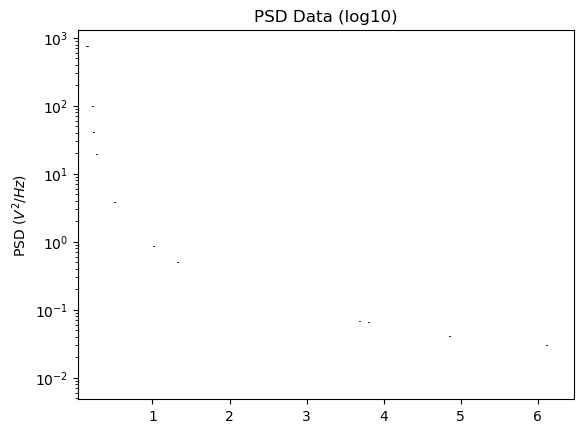

In [72]:
        d = app.process.processed_data
        xf, mpxx, epxx = d[0], d[1], d[3]
        plt.semilogy()
        points = 10 #Number of points on final graph
        points_sep = round(len(xf)/points)
        if points_sep < 1:
            points_sep = 1
        print(points_sep)
        plt.errorbar(xf, mpxx, yerr = epxx, marker='', ms=100, linestyle='',color='black', alpha = 0.8)
        plt.title('PSD Data (log10)')
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/self.scale_x))
        plt.ylabel('PSD ($V^2/Hz$)')
        plt.xlim([xf[0],xf[-1]])

In [82]:
mpxx

array([7.32771097e+02, 7.34765237e+02, 7.36431416e+02, ...,
       1.00305923e-02, 8.89378063e-03, 8.48036498e-03])